### 1. 研究問題:如何藉分群結果提高紅利點數的取用與使用率
基於前一個專案的分析結果，發現五校在紅利點數的取用與使用的比例都不高，故希望可以透過分群的方式，找出各群的特徵，並藉不同的特徵思考如何利用行銷策略來增加取用與使用率。

### 2 分群分析想法
- 會員特徵
    - 會員基本資料 : 性別、年齡、學校
    - POS : 平均每年來店消費頻率、平均每年消費金額、最常使用的支付方式、消費品類、是否使用禮券支付、是否使用紅利支付
    - 兌換券 : 平均每年兌換頻率、兌換類別
    - 紅利點數 : 平均每年兌換頻率


### 3. 分析結果

### Packeages Import

In [261]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
# 設定全域字體大小
plt.rcParams['axes.titlesize'] = 16  # 圖形標題的字體大小
plt.rcParams['axes.labelsize'] = 14  # X、Y軸標籤的字體大小
plt.rcParams['xtick.labelsize'] = 12  # X軸刻度標籤的字體大小
plt.rcParams['ytick.labelsize'] = 12  # Y軸刻度標籤的字體大小
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = ['Arial', 'Microsoft JhengHei']  # 定義中英文字體

# 分群相關套件
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly
import seaborn as sns

### 4. 資料前處理
step1 : POS與會員資料合併  
step2 : 特徵選擇 : 消費頻率、消費金額、紅利使用次數、兌換券使用次數、產品品類偏好、是否使用禮券折抵、是否使用另折抵

In [106]:
# 保留客戶代號位數>6的資料,並整粒客戶代號新增至User_ID欄位，以待後續要與會員資料合併
pos = pd.read_csv('./raw_data/all_pos.csv')
pos = pos[pos['客戶代號'].astype(str).str.len() > 6]

# 提取數字部分並新增 UserID 欄位
pos['UserID'] = pos['客戶代號'].str.extract('(\d+)')

# 篩選出以 9 開頭的 UserID (因為後來篩出來的資料沒清乾淨所以多加這個條件)
pos = pos[pos['UserID'].str.startswith('9')]

# 顯示結果
pos.head()

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,刷卡金額,一卡通實付金額,LinePay實付金額,獲得紅利,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID
18,中山,D961360266,11001040090,110.01.04,Pentel 易拭型塑膠擦-小 #ZEL-05,2,設計、文具,10.0,20,84,...,0,0,0,84,0,0,0,0,0,961360266
19,中山,D961360266,11001040090,110.01.04,單面七彩索引片 17*26mm #WL-3066 華麗牌,1,設計、文具,12.0,12,84,...,0,0,0,84,0,0,0,0,0,961360266
20,中山,D961360266,11001040090,110.01.04,單面七彩索引片 17*42mm #WL-3065 華麗牌,1,設計、文具,12.0,12,84,...,0,0,0,84,0,0,0,0,0,961360266
21,中山,D961360266,11001040090,110.01.04,18K環保計算紙,2,設計、文具,20.0,40,84,...,0,0,0,84,0,0,0,0,0,961360266
22,中山,D963619834,11001040091,110.01.04,利百代LB5008CA工程計算機,1,設計、文具,199.0,199,199,...,0,0,0,199,0,0,0,0,0,963619834


In [107]:
member = pd.read_csv('./raw_data/(APP-會員含生日)mem20240403.csv')
member = member.drop(columns=['MBR_SCHOOL_ID','MBR_SCHOOL','CreatedDate','Birthday','UDF1','UDF4','Email','YahooID','UserName','ModifiedDate'])
member

,UserID,UserSex
0,919061387,0
1,916360484,1
2,983835662,1
3,979872208,0
4,979136556,0
...,...,...
20409,926796267,1
20410,903912882,1
20411,971236397,2
20412,988471089,1


In [108]:
# 將 UserID 欄位轉換為字串型別
member['UserID'] = member['UserID'].astype(str)
n_pos = pd.merge(pos,member, on = 'UserID', how='inner') # 只保留兩邊都擁有的UserID，撇除只有消費但沒有取用與使用紅利的帳戶
n_pos

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,一卡通實付金額,LinePay實付金額,獲得紅利,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,0,154,0,6600,0,22,0,955825516,0
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,0,154,0,6600,0,22,0,955825516,0
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,0,154,0,6600,0,22,0,955825516,0
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,0,154,0,6600,0,22,0,955825516,0
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,0,289,0,0,0,0,0,955825516,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,義大,B965704422,11303201261,113.03.20,逸盛 USB3.0轉RJ45(A+C)/1000M 高速網路卡(銀) 01-RJ,1,3C,399.0,399,458,...,0,0,458,0,0,0,0,0,965704422,1
205516,義大,B965704422,11303201261,113.03.20,花香清潔袋(玫瑰/香茅)3入-大,1,生活百貨,59.0,59,458,...,0,0,458,0,0,0,0,0,965704422,1
205517,義大,C905813630,11303201271,113.03.20,黃阿瑪的後宮生活 貓咪超有事3-貓貓美食救援計畫,1,社會書,264.0,264,0,...,0,0,264,0,0,0,0,0,905813630,1
205518,義大,B908879198,11303201296,113.03.20,Power BI 快速入門,1,教科書,441.0,441,441,...,0,0,441,0,0,0,0,0,908879198,0


In [109]:
# 定義轉換函數
def to_datetime(taiwan_date):
    # 將民國年轉換成西元年
    year_offset = 1911
    parts = taiwan_date.split('.')
    year = int(parts[0]) + year_offset
    month = int(parts[1])
    day = int(parts[2])

    # 使用 datetime 將日期數據解析成日期對象
    date_obj = datetime.datetime(year, month, day)

    return date_obj

In [110]:
n_pos['新結帳日期'] = n_pos['結帳日期'].apply(to_datetime)
n_pos

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,LinePay實付金額,獲得紅利,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex,新結帳日期
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,289,0,0,0,0,0,955825516,0,2021-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,義大,B965704422,11303201261,113.03.20,逸盛 USB3.0轉RJ45(A+C)/1000M 高速網路卡(銀) 01-RJ,1,3C,399.0,399,458,...,0,458,0,0,0,0,0,965704422,1,2024-03-20
205516,義大,B965704422,11303201261,113.03.20,花香清潔袋(玫瑰/香茅)3入-大,1,生活百貨,59.0,59,458,...,0,458,0,0,0,0,0,965704422,1,2024-03-20
205517,義大,C905813630,11303201271,113.03.20,黃阿瑪的後宮生活 貓咪超有事3-貓貓美食救援計畫,1,社會書,264.0,264,0,...,0,264,0,0,0,0,0,905813630,1,2024-03-20
205518,義大,B908879198,11303201296,113.03.20,Power BI 快速入門,1,教科書,441.0,441,441,...,0,441,0,0,0,0,0,908879198,0,2024-03-20


In [111]:
#擷取新結帳日期的年月日
n_pos['Year'] = n_pos['新結帳日期'].dt.year
n_pos['Month'] = n_pos['新結帳日期'].dt.month
n_pos.head()

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex,新結帳日期,Year,Month
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,0,0,0,0,955825516,0,2021-01-08,2021,1


#### 4.1會員年消費平均次數

In [112]:
feq = n_pos[['UserID','UserSex','單號','Year','Month']]

#擷取第一單的紀錄:因為有些是同一筆單號但有多樣商品結單紀錄
feq = feq.groupby(['UserID','單號'])[['UserSex','Year']].first().reset_index()

# 計算年總消費平均
year_feq = feq.groupby(['UserID','Year']).size().reset_index(name='年總消費次數')

# 計算每個會員的年平均消費次數
avg_feq = year_feq.groupby('UserID')['年總消費次數'].mean().reset_index(name='年平均消費次數')
avg_feq

,UserID,年平均消費次數
0,900002568,3.666667
1,900008283,5.000000
2,900009691,3.000000
3,900011046,6.000000
4,900020718,1.500000
...,...,...
14848,989984332,2.000000
14849,989985917,6.000000
14850,989986908,1.666667
14851,989991647,3.000000


#### 4.2會員年平均消費金額(包含紅利取用與使用禮券的金額)

In [113]:
consume = n_pos.groupby(['UserID','Year'])['實際銷售小計'].sum().reset_index(name='消費總額')
consume

,UserID,Year,消費總額
0,900002568,2022,1154
1,900002568,2023,413
2,900002568,2024,205
3,900008283,2023,479
4,900008283,2024,255
...,...,...,...
27149,989986908,2023,75
27150,989986908,2024,20
27151,989991647,2023,182
27152,989995376,2022,482


In [114]:
avgconsume = consume.groupby('UserID')['消費總額'].mean().reset_index(name='年平均消費金額')
avgconsume

,UserID,年平均消費金額
0,900002568,590.666667
1,900008283,367.000000
2,900009691,1361.500000
3,900011046,779.000000
4,900020718,1120.500000
...,...,...
14848,989984332,1052.500000
14849,989985917,2297.000000
14850,989986908,68.666667
14851,989991647,182.000000


#### 4.3會員消費類別總計

In [115]:
# 先找出消費總共有多少類別
n_pos['類別名稱'].unique()

array(['設計、文具', '促銷代碼', '穿搭配飾', '社會書', '學校紀念品', '可諾進出口', '3C', '教科書',
       '生活百貨', '蘋果原廠產品', '藍海經銷', '不計算業績', '業外', '二手書', '其他', '食品', '美妝',
       '簡體字書', 'X[麗文禮券.]'], dtype=object)

In [116]:
# 找出每個會員購買資訊
cosumeType=n_pos[['UserID','單號','類別名稱']]
cosumeType

,UserID,單號,類別名稱
0,955825516,11001060268,設計、文具
1,955825516,11001060268,設計、文具
2,955825516,11001060268,設計、文具
3,955825516,11001060268,促銷代碼
4,955825516,11001080297,穿搭配飾
...,...,...,...
205515,965704422,11303201261,3C
205516,965704422,11303201261,生活百貨
205517,905813630,11303201271,社會書
205518,908879198,11303201296,教科書


In [117]:
# 使用One-hot encoding，標示類別是否存在於此資料
cosumeType = pd.get_dummies(cosumeType, columns=['類別名稱'])
cosumeType

,UserID,單號,類別名稱_3C,類別名稱_X[麗文禮券.],類別名稱_不計算業績,類別名稱_二手書,類別名稱_促銷代碼,類別名稱_其他,類別名稱_可諾進出口,類別名稱_學校紀念品,...,類別名稱_業外,類別名稱_生活百貨,類別名稱_社會書,類別名稱_穿搭配飾,類別名稱_簡體字書,類別名稱_美妝,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品
0,955825516,11001060268,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,955825516,11001060268,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,955825516,11001060268,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,955825516,11001060268,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,955825516,11001080297,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,965704422,11303201261,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
205516,965704422,11303201261,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
205517,905813630,11303201271,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
205518,908879198,11303201296,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [118]:
# 將每個會員的所有購買過的類別記錄下來,並將單號移除
cosumeType=cosumeType.groupby(['UserID']).sum().reset_index()
cosumeType=cosumeType.drop(columns=['單號'])
cosumeType

,UserID,類別名稱_3C,類別名稱_X[麗文禮券.],類別名稱_不計算業績,類別名稱_二手書,類別名稱_促銷代碼,類別名稱_其他,類別名稱_可諾進出口,類別名稱_學校紀念品,類別名稱_教科書,類別名稱_業外,類別名稱_生活百貨,類別名稱_社會書,類別名稱_穿搭配飾,類別名稱_簡體字書,類別名稱_美妝,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品
0,900002568,0,0,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,19,0
1,900008283,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,20,0
2,900009691,2,0,0,0,1,0,0,0,2,0,2,1,0,0,0,0,0,1,0
3,900011046,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17,0
4,900020718,0,0,2,0,2,0,0,0,2,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,989984332,1,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,3,0
14849,989985917,1,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,18,0
14850,989986908,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,2,0
14851,989991647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0


#### 4.4是否曾經使用過紅利、禮券折抵

In [119]:
# 會員是否曾使用discount
n_pos['紅利取用標記'] = n_pos.groupby('UserID')['紅利取用'].transform(lambda x: 1 if x.sum() > 0 else 0)
n_pos['禮券折抵標記'] = n_pos.groupby('UserID')['禮券金額'].transform(lambda x: 1 if x.sum() > 0 else 0)
n_pos

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex,新結帳日期,Year,Month,紅利取用標記,禮券折抵標記
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,0,0,955825516,0,2021-01-08,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,義大,B965704422,11303201261,113.03.20,逸盛 USB3.0轉RJ45(A+C)/1000M 高速網路卡(銀) 01-RJ,1,3C,399.0,399,458,...,0,0,0,965704422,1,2024-03-20,2024,3,1,0
205516,義大,B965704422,11303201261,113.03.20,花香清潔袋(玫瑰/香茅)3入-大,1,生活百貨,59.0,59,458,...,0,0,0,965704422,1,2024-03-20,2024,3,1,0
205517,義大,C905813630,11303201271,113.03.20,黃阿瑪的後宮生活 貓咪超有事3-貓貓美食救援計畫,1,社會書,264.0,264,0,...,0,0,0,905813630,1,2024-03-20,2024,3,0,0
205518,義大,B908879198,11303201296,113.03.20,Power BI 快速入門,1,教科書,441.0,441,441,...,0,0,0,908879198,0,2024-03-20,2024,3,1,0


In [120]:
# 該會員是否曾使用
discountuseORnot = n_pos.groupby('UserID')[["紅利取用標記",'禮券折抵標記']].max()
discountuseORnot

,紅利取用標記,禮券折抵標記
UserID,,
900002568,1,0
900008283,0,0
900009691,0,0
900011046,0,0
900020718,0,0
...,...,...
989984332,0,0
989985917,1,0
989986908,0,0


In [121]:
# 會員使用折抵的頻率
discoutFre = n_pos[["UserID","單號",'紅利取用',"禮券金額","Year","Month"]]
# 去除重複紀錄
discoutFre=discoutFre.groupby(['UserID','單號'])[['紅利取用','禮券金額','Month',"Year"]].count().reset_index()
discoutFre

,UserID,單號,紅利取用,禮券金額,Month,Year
0,900002568,11110201172,2,2,2,2
1,900002568,11202201724,2,2,2,2
2,900002568,11203080497,1,1,1,1
3,900002568,11205020185,4,4,4,4
4,900002568,11209184727,2,2,2,2
...,...,...,...,...,...,...
89385,989995376,11210030642,2,2,2,2
89386,989995376,11210031398,1,1,1,1
89387,989995376,11210121742,1,1,1,1
89388,989995376,11210191371,1,1,1,1


In [122]:
# 各會員每年折抵使用頻綠
discoutFre = discoutFre.groupby(["UserID","Year"])[["紅利取用", "禮券金額"]].count().reset_index()
discoutFre

,UserID,Year,紅利取用,禮券金額
0,900002568,1,4,4
1,900002568,2,3,3
2,900002568,3,2,2
3,900002568,4,2,2
4,900008283,1,4,4
...,...,...,...,...
38893,989991647,1,2,2
38894,989991647,2,1,1
38895,989995376,1,10,10
38896,989995376,2,4,4


In [123]:
discoutFre=discoutFre.groupby(["UserID"])[["紅利取用", "禮券金額"]].mean().reset_index()
discoutFre

,UserID,紅利取用,禮券金額
0,900002568,2.750000,2.750000
1,900008283,2.500000,2.500000
2,900009691,2.000000,2.000000
3,900011046,4.000000,4.000000
4,900020718,1.500000,1.500000
...,...,...,...
14848,989984332,1.333333,1.333333
14849,989985917,1.500000,1.500000
14850,989986908,2.500000,2.500000
14851,989991647,1.500000,1.500000


#### 4.5支付方式類別比例

In [124]:
payType = n_pos[["UserID","單號",'已收現金',"刷卡金額","一卡通實付金額","LinePay實付金額","Year","Month"]]
payType

,UserID,單號,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額,Year,Month
0,955825516,11001060268,154,0,0,0,2021,1
1,955825516,11001060268,154,0,0,0,2021,1
2,955825516,11001060268,154,0,0,0,2021,1
3,955825516,11001060268,154,0,0,0,2021,1
4,955825516,11001080297,289,0,0,0,2021,1
...,...,...,...,...,...,...,...,...
205515,965704422,11303201261,458,0,0,0,2024,3
205516,965704422,11303201261,458,0,0,0,2024,3
205517,905813630,11303201271,0,264,0,0,2024,3
205518,908879198,11303201296,441,0,0,0,2024,3


In [125]:
payType = payType.groupby(["UserID","單號"])[["已收現金","刷卡金額","一卡通實付金額","LinePay實付金額"]].max().reset_index()
payType

,UserID,單號,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額
0,900002568,11110201172,0,1154,0,0
1,900002568,11202201724,8,0,0,0
2,900002568,11203080497,36,0,0,0
3,900002568,11205020185,0,0,0,132
4,900002568,11209184727,85,0,0,0
...,...,...,...,...,...,...
89385,989995376,11210030642,54,0,0,0
89386,989995376,11210031398,93,0,0,0
89387,989995376,11210121742,470,0,0,0
89388,989995376,11210191371,64,0,0,0


In [126]:
payType['已收現金'] = (payType['已收現金'] > 0).astype(int)
payType['刷卡金額'] = (payType['刷卡金額'] > 0).astype(int)
payType['一卡通實付金額'] = (payType['一卡通實付金額'] > 0).astype(int)
payType['LinePay實付金額'] = (payType['LinePay實付金額'] > 0).astype(int)
payType

,UserID,單號,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額
0,900002568,11110201172,0,1,0,0
1,900002568,11202201724,1,0,0,0
2,900002568,11203080497,1,0,0,0
3,900002568,11205020185,0,0,0,1
4,900002568,11209184727,1,0,0,0
...,...,...,...,...,...,...
89385,989995376,11210030642,1,0,0,0
89386,989995376,11210031398,1,0,0,0
89387,989995376,11210121742,1,0,0,0
89388,989995376,11210191371,1,0,0,0


In [127]:
# 會員支付方式比例
payType = payType.groupby(["UserID"])[["已收現金", "刷卡金額","一卡通實付金額","LinePay實付金額"]].mean().reset_index()
payType

,UserID,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額
0,900002568,0.636364,0.181818,0.0,0.181818
1,900008283,1.000000,0.000000,0.0,0.000000
2,900009691,0.666667,0.333333,0.0,0.000000
3,900011046,0.750000,0.250000,0.0,0.000000
4,900020718,1.000000,0.000000,0.0,0.000000
...,...,...,...,...,...
14848,989984332,1.000000,0.000000,0.0,0.000000
14849,989985917,0.500000,0.000000,0.0,0.166667
14850,989986908,1.000000,0.000000,0.0,0.000000
14851,989991647,1.000000,0.000000,0.0,0.000000


#### 4.6合併上述特徵

In [128]:
member = n_pos[["UserID",'倉別名稱',"UserSex"]]
member.drop_duplicates(subset=['UserID'],inplace=True)
member = pd.get_dummies(member, columns=['倉別名稱'])
member

C:\Users\Shelly\AppData\Local\Temp\ipykernel_14004\2051662817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member.drop_duplicates(subset=['UserID'],inplace=True)


,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大
0,955825516,0,True,False,False,False,False
10,903632160,1,True,False,False,False,False
21,983835662,1,True,False,False,False,False
23,979872208,0,True,False,False,False,False
34,979878010,2,True,False,False,False,False
...,...,...,...,...,...,...,...
205396,983020530,0,False,False,False,False,True
205399,958016116,1,False,False,False,False,True
205465,916420981,1,False,False,False,False,True
205476,982020831,0,False,False,False,False,True


In [129]:
# 合并所有表到 "member" 表中
member = member.merge(avgconsume, on='UserID', how='left')
member = member.merge(avg_feq, on='UserID', how='left')
member = member.merge(cosumeType, on='UserID', how='left')
member = member.merge(payType, on='UserID', how='left')
member = member.merge(discoutFre, on='UserID', how='left')
member

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額,紅利取用,禮券金額
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,0,5,72,0,1.000,0.0,0.00,0.00,4.714286,4.714286
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,0,6,0,0.625,0.0,0.00,0.25,2.666667,2.666667
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,0,1,15,1,1.000,0.0,0.00,0.00,3.000000,3.000000
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,0,13,0,1.000,0.0,0.00,0.00,2.000000,2.000000
4,979878010,2,True,False,False,False,False,1722.750000,5.000000,3,...,0,1,29,0,0.650,0.0,0.05,0.30,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,0,1,0,1.000,0.0,0.00,0.00,1.000000,1.000000
14849,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0,0.000,1.0,0.00,0.00,1.000000,1.000000
14850,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.00,0.00,1.000000,1.000000
14851,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.00,0.00,1.000000,1.000000


In [130]:
# 去掉UserSex為2的資料
member = member[member['UserSex'] != 2]
member

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額,紅利取用,禮券金額
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,0,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,0,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000
5,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000
14849,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000
14850,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000
14851,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000


In [131]:
# 重新整理欄位名稱
member = member.rename(columns={
    '已收現金': '現金支付比例',
    '刷卡金額': '刷卡支付比例',
    '一卡通實付金額': '一卡通支付比例',
    'LinePay實付金額': 'LinePay支付比例',
    '紅利取用': '紅利年平均折抵次數',
    '禮券金額': '禮卷年平均折抵次數'
})
member

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,0,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,0,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000
5,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000
14849,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000
14850,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000
14851,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000


#### 4.7年平均兌換兌換券次數

In [132]:
coupon = pd.read_csv('./raw_data/(APP-點數兌換)_coupon.csv')
coupon

,MBR_SCHOOL_ID,MBR_SCHOOL,UserID,UserName,UserSex,UDF1,UDF4,Email,YahooID,PointDate,CouponCode,Name,Amount,IsUsed,AssignDate,ExpireDate
0,09,國立中山大學,900761212,侯佩妘,1,2021,NaN,peggy10341@gmail.com,D900761212,2022-06-18 00:11:47.480,D172,【門市取貨】UNI 限定版小小兵摩樂筆（款式隨機）,10,1,2022-06-18 12:30:18.557,2022-09-06 17:33:09.253
1,09,國立中山大學,900761212,侯佩妘,1,2021,NaN,peggy10341@gmail.com,D900761212,2021-12-30 08:13:27.313,C036,【門市取貨】熊熊捲線器,8,1,2021-12-30 12:16:07.930,2022-01-14 12:09:24.993
2,09,國立中山大學,902166568,張少銘,0,2021,三年級甲班,eric21204311@gmail.com,D902166568,2022-09-08 10:38:43.263,Z220,【門市獨家活動】（09/06上架）開學折抵金 5元,500,1,2022-09-08 10:40:06.090,2022-09-13 10:46:22.500
3,09,國立中山大學,902329869,陳威保,0,2021,NaN,1l3920901@gmaip.com,D902329869,2021-10-26 12:03:43.003,Z041,【會員大好康】100點免費抽(舒適生活空氣清淨機抽獎卷5),200,1,2021-10-26 12:26:32.220,2021-10-26 12:26:52.127
4,09,國立中山大學,903483681,陸嘉康,0,2021,NaN,aron920102@gmail.com,D903483681,2022-02-23 14:42:58.923,Z121,【門市專用】50元消費折抵金（2022/02）,100,1,2022-02-23 15:52:01.177,2022-02-23 15:52:12.777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,G6,義守大學(醫學院分部),988634590,陳沛妤,1,2023,NaN,sky245680@gmail.com,C988634590,2023-09-21 17:29:16.567,Z9-23,【門市取貨】麥香紅茶300ml(限量),6240,1,2023-09-21 17:30:15.067,2023-09-21 17:31:02.223
6403,G6,義守大學(醫學院分部),988763076,蔡秉儒,1,2023,NaN,isu11256042A@cloud.isu.edu.tw,B988763076,2023-09-07 11:39:33.283,P2309-7,【義守大學專屬】50點免費抽：義大遊樂世界門票／兩張一組(0907),100,1,2023-09-07 11:41:32.440,2023-09-07 11:41:39.220
6404,G6,義守大學(醫學院分部),988763076,蔡秉儒,1,2023,NaN,isu11256042A@cloud.isu.edu.tw,B988763076,2023-09-07 11:39:33.283,Z9-23,【門市取貨】麥香紅茶300ml(限量),6240,1,2023-09-07 11:41:02.440,2023-09-07 11:41:07.827
6405,G6,義守大學(醫學院分部),988964113,賴巧蓉,1,2023,一,Cindy0988964113,C988964113,2023-09-21 12:43:57.207,Z9-23,【門市取貨】麥香紅茶300ml(限量),6240,1,2023-09-21 12:44:41.880,2023-09-21 12:44:48.690


In [133]:
# 兌換資料整理
coupon = coupon.drop(columns=['UDF1','UDF4','Email','YahooID','MBR_SCHOOL_ID'])
coupon['Name'] = coupon['Name'].str.extract(r'【(.*?)】')
coupon

,MBR_SCHOOL,UserID,UserName,UserSex,PointDate,CouponCode,Name,Amount,IsUsed,AssignDate,ExpireDate
0,國立中山大學,900761212,侯佩妘,1,2022-06-18 00:11:47.480,D172,門市取貨,10,1,2022-06-18 12:30:18.557,2022-09-06 17:33:09.253
1,國立中山大學,900761212,侯佩妘,1,2021-12-30 08:13:27.313,C036,門市取貨,8,1,2021-12-30 12:16:07.930,2022-01-14 12:09:24.993
2,國立中山大學,902166568,張少銘,0,2022-09-08 10:38:43.263,Z220,門市獨家活動,500,1,2022-09-08 10:40:06.090,2022-09-13 10:46:22.500
3,國立中山大學,902329869,陳威保,0,2021-10-26 12:03:43.003,Z041,會員大好康,200,1,2021-10-26 12:26:32.220,2021-10-26 12:26:52.127
4,國立中山大學,903483681,陸嘉康,0,2022-02-23 14:42:58.923,Z121,門市專用,100,1,2022-02-23 15:52:01.177,2022-02-23 15:52:12.777
...,...,...,...,...,...,...,...,...,...,...,...
6402,義守大學(醫學院分部),988634590,陳沛妤,1,2023-09-21 17:29:16.567,Z9-23,門市取貨,6240,1,2023-09-21 17:30:15.067,2023-09-21 17:31:02.223
6403,義守大學(醫學院分部),988763076,蔡秉儒,1,2023-09-07 11:39:33.283,P2309-7,義守大學專屬,100,1,2023-09-07 11:41:32.440,2023-09-07 11:41:39.220
6404,義守大學(醫學院分部),988763076,蔡秉儒,1,2023-09-07 11:39:33.283,Z9-23,門市取貨,6240,1,2023-09-07 11:41:02.440,2023-09-07 11:41:07.827
6405,義守大學(醫學院分部),988964113,賴巧蓉,1,2023-09-21 12:43:57.207,Z9-23,門市取貨,6240,1,2023-09-21 12:44:41.880,2023-09-21 12:44:48.690


In [134]:
# 兌換時間整理
coupon['AssignDate'] = pd.to_datetime(coupon['AssignDate'])

# 新增年、月的欄位
coupon['Year'] = coupon['AssignDate'].dt.year
coupon['Month'] = coupon['AssignDate'].dt.month
coupon = coupon.drop(columns=['PointDate', 'AssignDate', 'ExpireDate'])
coupon = coupon.drop(columns=['CouponCode', 'Amount', 'IsUsed'])
coupon

,MBR_SCHOOL,UserID,UserName,UserSex,Name,Year,Month
0,國立中山大學,900761212,侯佩妘,1,門市取貨,2022,6
1,國立中山大學,900761212,侯佩妘,1,門市取貨,2021,12
2,國立中山大學,902166568,張少銘,0,門市獨家活動,2022,9
3,國立中山大學,902329869,陳威保,0,會員大好康,2021,10
4,國立中山大學,903483681,陸嘉康,0,門市專用,2022,2
...,...,...,...,...,...,...,...
6402,義守大學(醫學院分部),988634590,陳沛妤,1,門市取貨,2023,9
6403,義守大學(醫學院分部),988763076,蔡秉儒,1,義守大學專屬,2023,9
6404,義守大學(醫學院分部),988763076,蔡秉儒,1,門市取貨,2023,9
6405,義守大學(醫學院分部),988964113,賴巧蓉,1,門市取貨,2023,9


In [135]:
# 各會員年兌換頻率
member_coupon_freq=coupon.groupby(['UserID','Year']).size().reset_index(name='年總兌換次數')
avgcoupon_freq = member_coupon_freq.groupby('UserID')['年總兌換次數'].mean().reset_index(name='年平均兌換頻率')
avgcoupon_freq

,UserID,年平均兌換頻率
0,900002568,1.0
1,900008283,1.0
2,900029578,1.0
3,900029961,1.0
4,900030001,1.0
...,...,...
3508,989919690,1.0
3509,989971965,11.0
3510,989972056,1.0
3511,989981078,1.0


#### 4.8所有購買行為合併

In [136]:
# 轉換資料型態、合併
avgcoupon_freq['UserID'] = avgcoupon_freq['UserID'].astype(str)

allfeature= pd.merge(member,avgcoupon_freq, how = 'left', on = 'UserID')
allfeature

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,NaN
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,NaN
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,NaN
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,NaN
4,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,NaN
14087,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,NaN
14088,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,NaN
14089,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,NaN


In [137]:
# 將年平均兌換頻率為空值的資料填充0
allfeature['年平均兌換頻率'].fillna(0, inplace=True)
allfeature

C:\Users\Shelly\AppData\Local\Temp\ipykernel_14004\1762420872.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  allfeature['年平均兌換頻率'].fillna(0, inplace=True)


,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,0.0
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,0.0
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,0.0
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,0.0
4,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,0.0
14087,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,0.0
14088,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0
14089,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0


### 5. 整體資料分群

#### 5.1 標準化

- 目的是將數據的不同特徵轉換到同一尺度上，從而使每個特徵對模型的影響力相當。
- 標準化的常見方法是將數據轉換為均值為0、標準差為1的標準正態分佈，這通常使用StandardScaler來實現。

- 標準化數值表示每個數據點距離該特徵的均值有多少個標準差。具體來說：

    - 正數值：表示該數據點高於均值，數值越大，表示離均值越遠。
    - 負數值：表示該數據點低於均值，數值越小，表示離均值越遠。
    - 接近0的數值：表示該數據點接近均值。

In [142]:
# 指定需要標準化的欄位欄位
cols_to_normalize = ['年平均消費金額', '年平均消費次數','現金支付比例', '刷卡支付比例', '一卡通支付比例', 'LinePay支付比例','類別名稱_3C', '類別名稱_二手書', '類別名稱_其他',
       '類別名稱_可諾進出口', '類別名稱_學校紀念品', '類別名稱_教科書', '類別名稱_生活百貨', '類別名稱_社會書',
       '類別名稱_穿搭配飾', '類別名稱_簡體字書', '類別名稱_美妝', '類別名稱_藍海經銷', '類別名稱_蘋果原廠產品',
       '類別名稱_設計、文具', '類別名稱_食品']

# 建立StandardScaler對象
scaler = StandardScaler()
df_normalized = allfeature.copy()
df_normalized[cols_to_normalize] = scaler.fit_transform(allfeature[cols_to_normalize])
df_normalized

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,955825516,0,True,False,False,False,False,0.432686,5.929771,0.422118,...,24.263389,6.232053,-0.086102,0.682939,-0.30416,-0.398986,-0.388333,4.714286,4.714286,0.0
1,903632160,1,True,False,False,False,False,-0.269363,-0.123244,0.422118,...,-0.093688,-0.071220,-0.086102,-0.437373,-0.30416,-0.398986,0.696912,2.666667,2.666667,0.0
2,983835662,1,True,False,False,False,False,-0.116889,0.350787,-0.363935,...,4.777728,0.788317,2.917016,0.682939,-0.30416,-0.398986,-0.388333,3.000000,3.000000,0.0
3,979872208,0,True,False,False,False,False,0.144743,0.168468,0.422118,...,-0.093688,0.597309,-0.086102,0.682939,-0.30416,-0.398986,-0.388333,2.000000,2.000000,0.0
4,919061387,0,True,False,False,False,False,-0.231612,-0.196172,0.422118,...,-0.093688,-0.357732,-0.086102,0.682939,-0.30416,-0.398986,-0.388333,2.500000,2.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,False,False,False,False,True,-0.352078,-0.852523,-0.363935,...,-0.093688,-0.548740,-0.086102,0.682939,-0.30416,-0.398986,-0.388333,1.000000,1.000000,0.0
14087,958016116,1,False,False,False,False,True,-0.275952,-0.852523,0.422118,...,-0.093688,-0.644244,-0.086102,-2.304560,5.40345,-0.398986,-0.388333,1.000000,1.000000,0.0
14088,916420981,1,False,False,False,False,True,-0.025138,-0.852523,-0.363935,...,-0.093688,-0.644244,-0.086102,0.682939,5.40345,-0.398986,-0.388333,1.000000,1.000000,0.0
14089,982020831,0,False,False,False,False,True,-0.140795,-0.852523,-0.363935,...,-0.093688,-0.644244,-0.086102,0.682939,5.40345,-0.398986,-0.388333,1.000000,1.000000,0.0


#### 5.2 k-means

- 使用Elbow Method決定整體資料的最佳分群數

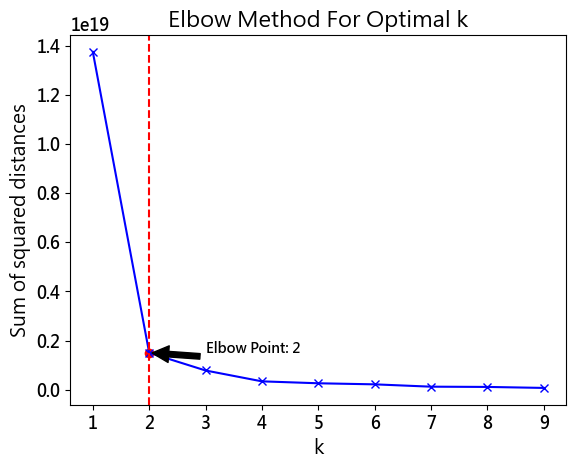

The optimal number of clusters determined by the Elbow Method is: 2


In [ ]:
# 定義聚類數量 k 的範圍
K = range(1, 10)
sum_of_squared_distances = []

# 逐步計算不同 k 值的 KMeans 模型
for k in K:
    km = KMeans(n_clusters=k, random_state=42)  
    km = km.fit(df_normalized)                  
    sum_of_squared_distances.append(km.inertia_) 

# 計算斜率變化
differences = np.diff(sum_of_squared_distances)      
second_differences = np.diff(differences)            

# 找到斜率變化最大的點，即肘部點
elbow_point = np.argmax(second_differences) + 2      # +2 是因為經過兩次差分，索引的位置比員數據少了兩個元素

# 繪製 Elbow Method 圖
plt.plot(K, sum_of_squared_distances, 'bx-')         
plt.xlabel('k')                                    
plt.ylabel('Sum of squared distances')               
plt.title('Elbow Method For Optimal k')              

# 標記肘部點
plt.axvline(x=elbow_point, color='r', linestyle='--') 
plt.scatter(elbow_point, sum_of_squared_distances[elbow_point - 1], color='red') 

# 添加備註文字
plt.annotate(f'Elbow Point: {elbow_point}', 
             xy=(elbow_point, sum_of_squared_distances[elbow_point - 1]), 
             xytext=(elbow_point + 1, sum_of_squared_distances[elbow_point - 1] + 1000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# 輸出最佳分類數量
print(f"The optimal number of clusters determined by the Elbow Method is: {elbow_point}")


- k-means模型建立與訓練

In [ ]:
best_k =2
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(df_normalized)

KMeans(n_clusters=2, random_state=42)

- 計算 Silhouette Score 衡量分群效果
- 為0.789接近1，表示分群效果好

In [ ]:
score = silhouette_score(df_normalized, kmeans.labels_)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.7894846593056813


- 將分群結果加入資料表，以便進一步分析不同具類的特徵分布

In [192]:
cluster_full=allfeature.copy()
cluster_full['Cluster'] = kmeans.labels_
cluster_full

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率,Cluster
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,0.0,1
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,0.0,0
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,0.0,1
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,0.0,1
4,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,0.0,1
14087,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,0.0,1
14088,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0,0
14089,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0,1


##### PCA
- 檢查群組之間的邊界和重疊情況

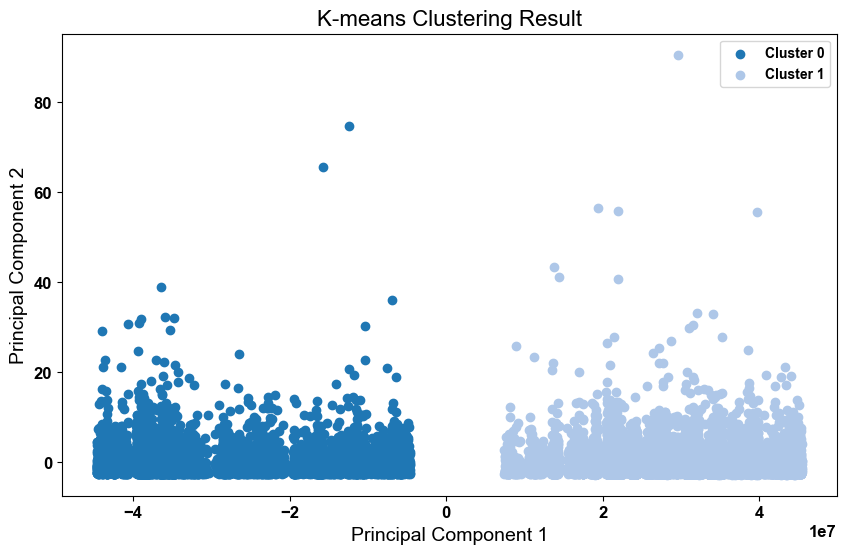

In [188]:
# 使用 PCA 將數據降到二维
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_normalized)

# 將分群結果加到df裡
df_visualize = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_visualize['cluster'] = kmeans.labels_

colors = plt.colormaps['tab20']

# 繪製散點圖
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    cluster_data = df_visualize[df_visualize['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], color=colors(cluster), label=f'Cluster {cluster}')

plt.title('K-means Clustering Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

- 透過上圖的 PCA 降維可以發現都聚攏於PC1附近，表示 PCA 可能只是別出一個主導變異方向，或是資料為非線性所以無法拆解出特徵間的變異
- 故接下來透過t-SNE的方式來識別非線性資料

##### t-SNE
- 識別出資料點在高維度的分布效果

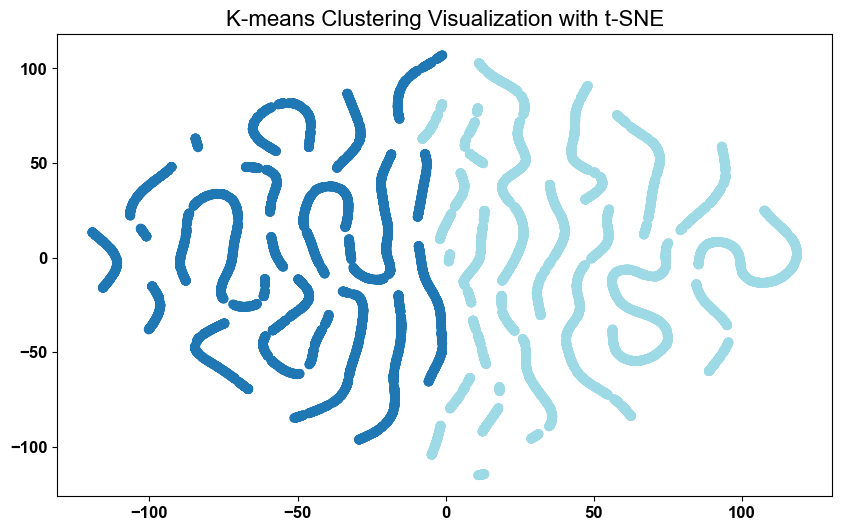

In [202]:
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(df_normalized)

# 建立 t-SNE 結果 DataFrame
tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans.labels_, cmap='tab20')
plt.title('K-means Clustering Visualization with t-SNE')
plt.show()

In [200]:
# 計算每個群組的特徵統計量
pd.set_option('display.max_columns', None)
cluster_summary = cluster_full.groupby('Cluster').describe().reset_index()
cluster_summary

Cluster UserSex                                              年平均消費金額  \
            count      mean       std  min  25%  50%  75%  max   count   
0       0  6846.0  0.512854  0.499871  0.0  0.0  1.0  1.0  1.0  6846.0   
1       1  7245.0  0.537474  0.498628  0.0  0.0  1.0  1.0  1.0  7245.0   

                                                                      年平均消費次數  \
          mean          std  min    25%    50%          75%       max   count   
0  1387.670270  4438.651098  0.0  373.0  777.5  1523.375000  277685.0  6846.0   
1  1376.855694  2940.657220  0.0  365.5  781.5  1546.333333  101350.0  7245.0   

                                                          類別名稱_3C            \
       mean       std  min  25%       50%  75%        max   count      mean   
0  2.948401  2.286656  1.0  1.0  2.333333  4.0  30.666667  6846.0  0.488899   
1  2.948252  2.284455  1.0  1.0  2.000000  4.0  28.000000  7245.0  0.438509   

                                      類別名稱_X[麗文禮券.]                           \
        std  min  25%  50%  75%   max         count      mean       std  min   
0  1.348248  0.0  0.0  0.0  0.0  35.0        6846.0  0.000146  0.012086  0.0   
1  1.195534  0.0  0.0  0.0  0.0  21.0        7245.0  0.001380  0.052526  0.0   

                      類別名稱_不計算業績                                          \
   25%  50%  75%  max      count      mean       std  min  25%  50%  75%   
0  0.0  0.0  0.0  1.0     6846.0  0.920245  2.223076  0.0  0.0  0.0  1.0   
1  0.0  0.0  0.0  3.0     7245.0  0.902277  2.363817  0.0  0.0  0.0  1.0   

        類別名稱_二手書                                              類別名稱_促銷代碼  \
    max    count      mean       std  min  25%  50%  75%  max     count   
0  61.0   6846.0  0.004528  0.098831  0.0  0.0  0.0  0.0  6.0    6846.0   
1  76.0   7245.0  0.004693  0.087798  0.0  0.0  0.0  0.0  3.0    7245.0   

                                                類別名稱_其他                      \
       mean       std  min  25%  50%  75%   max   count      mean       std   
0  1.706836  2.917182  0.0  0.0  1.0  2.0  74.0  6846.0  0.121969  1.848979   
1  1.791442  3.245603  0.0  0.0  1.0  2.0  98.0  7245.0  0.122705  1.942929   

                            類別名稱_可諾進出口                                     \
   min  25%  50%  75%   max      count      mean       std  min  25%  50%   
0  0.0  0.0  0.0  0.0  60.0     6846.0  0.030529  0.197360  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  75.0     7245.0  0.032574  0.208963  0.0  0.0  0.0   

            類別名稱_學校紀念品                                               類別名稱_教科書  \
   75%  max      count      mean       std  min  25%  50%  75%   max    count   
0  0.0  3.0     6846.0  0.142273  0.666360  0.0  0.0  0.0  0.0  19.0   6846.0   
1  0.0  4.0     7245.0  0.134300  0.569364  0.0  0.0  0.0  0.0  11.0   7245.0   

                                                 類別名稱_業外                      \
       mean       std  min  25%  50%  75%    max   count      mean       std   
0  1.625329  2.616014  0.0  0.0  1.0  2.0   85.0  6846.0  0.128980  0.639475   
1  1.644859  2.918817  0.0  0.0  1.0  2.0  142.0  7245.0  0.129883  0.820329   

                            類別名稱_生活百貨                                          \
   min  25%  50%  75%   max     count      mean       std  min  25%  50%  75%   
0  0.0  0.0  0.0  0.0  14.0    6846.0  0.822670  3.097979  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  42.0    7245.0  0.806211  2.867253  0.0  0.0  0.0  0.0   

        類別名稱_社會書                                               類別名稱_穿搭配飾  \
    max    count      mean       std  min  25%  50%  75%   max     count   
0  75.0   6846.0  0.945370  3.076895  0.0  0.0  0.0  1.0  86.0    6846.0   
1  76.0   7245.0  0.902139  2.675936  0.0  0.0  0.0  1.0  81.0    7245.0   

                                               類別名稱_簡體字書                      \
       mean       std  min  25%  50%  75%  max     count      mean       std   
0  0.044552  0.290440  0.0  0.0  0.0  0.0  6.0    6846.0  0.007011  0.1592

#### 5.3 每個群組的特徵統計量

- 此分群顯示兩群在紅利年平均折抵次數、禮券年平均折抵次數、年平均兌換頻率都沒有明顯的變化，以下以 Cluster 0 和 Cluster 1 呈現。

| Cluster | 紅利年平均折抵次數 | 禮券年平均折抵次數 | 年平均兌換頻率 |
|---------|----------------|----------------|--------------|
| 0       | 2.031373       | 2.031379       | 0.346528     |
| 1       | 2.029598       | 2.029598       | 0.343156     |

- 故接下來針對會員線上優惠的使用行為進行更進一步分群。


### 6. 紅利相關資料分群

In [204]:
features_to_cluster = ['紅利年平均折抵次數','禮卷年平均折抵次數','年平均兌換頻率']

#### 6.1 k-means

- 使用Elbow Method決定選擇特徵的最佳分群數

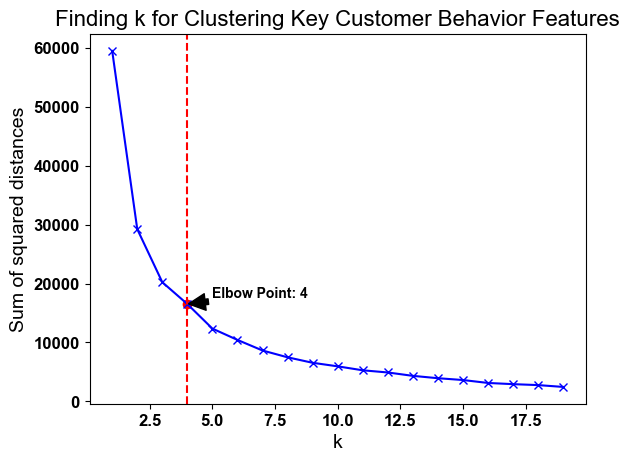

The optimal number of clusters determined by the Elbow Method is: 4


In [217]:
K = range(1, 20)
sum_of_squared_distances = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(df_normalized[features_to_cluster])
    sum_of_squared_distances.append(km.inertia_)

# 計算斜率變化
differences = np.diff(sum_of_squared_distances)
second_differences = np.diff(differences)

# 找到斜率變化最大的點，即肘部點
elbow_point = np.argmin(second_differences) + 2   # +2 是因為經過兩次差分，索引的位置比員數據少了兩個元素

# 繪製 Elbow Method 图
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Finding k for Clustering Key Customer Behavior Features')

# 標記肘部點
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.scatter(elbow_point, sum_of_squared_distances[elbow_point - 1], color='red')
plt.annotate(f'Elbow Point: {elbow_point}', xy=(elbow_point, sum_of_squared_distances[elbow_point - 1]),
             xytext=(elbow_point + 1, sum_of_squared_distances[elbow_point - 1] + 1000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

print(f"The optimal number of clusters determined by the Elbow Method is: {elbow_point}")


- k-means模型建立與訓練

In [218]:
selected_best_k = 4
kmeans = KMeans(n_clusters=selected_best_k, random_state=42)
kmeans.fit(df_normalized[features_to_cluster])

KMeans(n_clusters=4, random_state=42)

- 計算 Silhouette Score 衡量分群效果
- 為0.5，表示分群結果尚可，可能有部分分群重疊

In [219]:
score1 = silhouette_score(df_normalized[features_to_cluster], kmeans.labels_)
print(f'Silhouette Score: {score1}')

Silhouette Score: 0.5008964401630531


In [220]:
kmeans_cluster_discountOnly=allfeature.copy()
kmeans_cluster_discountOnly['Cluster'] = kmeans.labels_
kmeans_cluster_discountOnly

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,類別名稱_X[麗文禮券.],類別名稱_不計算業績,類別名稱_二手書,類別名稱_促銷代碼,類別名稱_其他,類別名稱_可諾進出口,類別名稱_學校紀念品,類別名稱_教科書,類別名稱_業外,類別名稱_生活百貨,類別名稱_社會書,類別名稱_穿搭配飾,類別名稱_簡體字書,類別名稱_美妝,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率,Cluster
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,0,0,0,4,0,0,3,0,0,1,1,1,0,0,0,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,0.0,1
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,0,1,0,4,0,0,0,0,0,0,2,0,0,0,0,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,0.0,0
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,0,2,0,3,0,0,0,3,0,1,3,0,0,0,0,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,0.0,1
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,0,0,0,3,0,1,10,1,0,0,0,1,0,0,0,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,0.0,0
4,919061387,0,True,False,False,False,False,515.000000,2.500000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,False,False,False,False,True,64.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,0.0,3
14087,958016116,1,False,False,False,False,True,349.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,0.0,3
14088,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0,3
14089,982020831,0,False,False,False,False,True,855.000000,1.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0,3


##### PCA

- 檢查群組之間的邊界和重疊情況

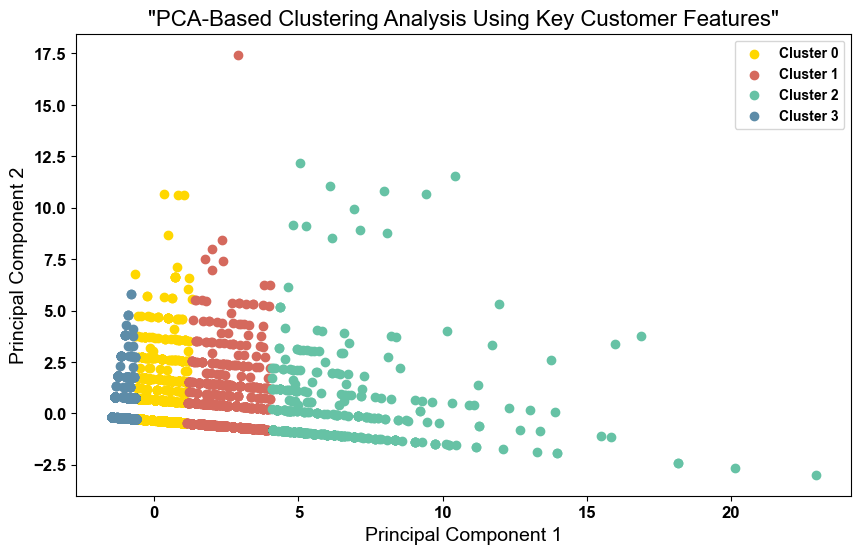

In [239]:
# 使用 PCA 將數據降到二维
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_normalized[features_to_cluster])

# 將分群結果加到df裡
df_visualize = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_visualize['Cluster'] = kmeans.labels_


# 繪製散點圖
plt.figure(figsize=(10, 6))
colors = ["#FFD700", "#d5695d", "#66c2a5", "#5d8ca8"]
for cluster in range(selected_best_k):
    cluster_data = df_visualize[df_visualize['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                color=colors[cluster], label=f'Cluster {cluster}')

plt.title('"PCA-Based Clustering Analysis Using Key Customer Features"')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [246]:
print(pca.explained_variance_ratio_)

[0.82322001 0.17677999]


- 透過上圖的 PCA 降維可以發現不同群組間有一定程度的分離，但仍有部分重疊
- PC1的影響較大，大部分的數據點都是沿著PC1軸展開，表示PC1可能解釋了主要變異
- 因為PC1+PC2已經解釋了整體的變異數，所以不需要進一步查看PC3，而是使用t-SNE來看看資料點的實際分佈效果

##### t-SNE

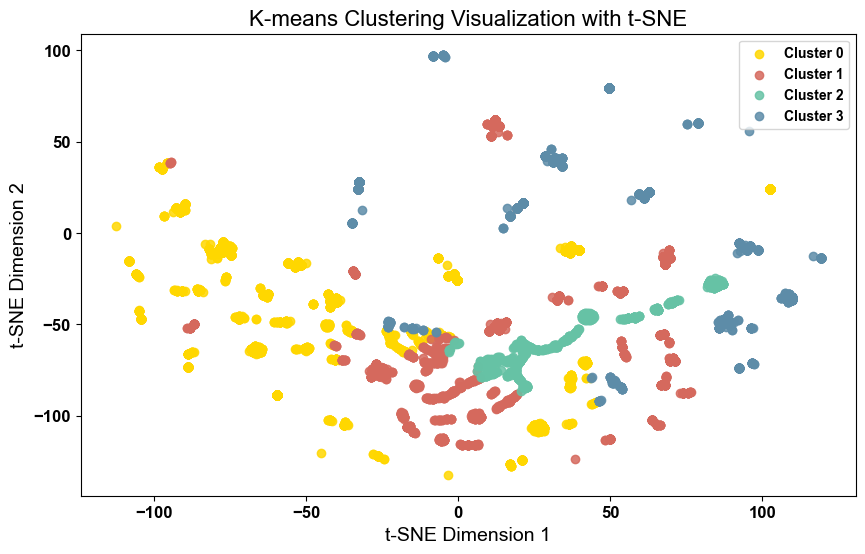

In [244]:
# t-SNE 降維
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_normalized[features_to_cluster])

# 建立 t-SNE 結果 DataFrame
df_tsne = pd.DataFrame(tsne_results, columns=['Dim1', 'Dim2'])
df_tsne['Cluster'] = kmeans.labels_

# 使用與 PCA 一樣的顏色
colors = ["#FFD700", "#d5695d", "#66c2a5", "#5d8ca8"] # 確保顏色順序相同

plt.figure(figsize=(10, 6))
for cluster in range(selected_best_k):
    cluster_data = df_tsne[df_tsne['Cluster'] == cluster]
    plt.scatter(cluster_data['Dim1'], cluster_data['Dim2'], 
                color=colors[cluster], label=f'Cluster {cluster}', alpha=0.85)

plt.title("K-means Clustering Visualization with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

- 相較於PCA，t-SNE更好的分散資料點，使不同群組間隔更加明顯
- 但Cluster 3 仍然有一些與其他群族重疊的情況，表示這些點在高維度中沒有明確的分界


#### 6.2 每個群組的特徵統計量
| Cluster | 紅利年平均折抵次數 | 禮券年平均折抵次數 | 年平均兌換頻率 |
|---------|----------------|----------------|--------------|
| 0       | 2.103742       | 2.103742       | 0.397568     |
| 1       | 3.522406       | 3.522406       | 0.536507     |
| 2       | 6.215343       | 6.215343       | 0.948697     |
| 3       | 1.122193       | 1.122193       | 0.194603     |

In [254]:
pd.set_option('display.max_columns', None)
cluster_summary = kmeans_cluster_discountOnly.groupby('Cluster').describe().reset_index()
cluster_summary

Cluster UserSex                                              年平均消費金額  \
            count      mean       std  min  25%  50%  75%  max   count   
0       0  4372.0  0.537511  0.498648  0.0  0.0  1.0  1.0  1.0  4372.0   
1       1  2269.0  0.523579  0.499554  0.0  0.0  1.0  1.0  1.0  2269.0   
2       2   601.0  0.507488  0.500360  0.0  0.0  1.0  1.0  1.0   601.0   
3       3  6849.0  0.520076  0.499633  0.0  0.0  1.0  1.0  1.0  6849.0   

                                                                       \
          mean          std        min         25%      50%       75%   
0  1495.661177  2647.681280   9.000000  479.500000   931.75  1730.625   
1  2113.360034  7395.807183  12.000000  638.666667  1198.00  2108.500   
2  2438.867443  4054.586272  44.666667  856.000000  1458.00  2620.750   
3   974.639546  2088.220827   0.000000  212.000000   587.00  1122.000   

            年平均消費次數                                                      \
        max   count      mean       std   min       25%       50%   75%   
0   69330.0  4372.0  3.299482  1.710581  1.00  2.000000  3.000000  4.00   
1  277685.0  2269.0  4.723079  2.374993  1.00  3.000000  4.333333  6.00   
2   55128.5   601.0  7.441348  4.307338  1.25  4.666667  6.500000  9.25   
3   94502.5  6849.0  1.741945  1.017859  1.00  1.000000  1.500000  2.00   

             類別名稱_3C                                                \
         max   count      mean       std  min  25%  50%  75%   max   
0  22.000000  4372.0  0.470265  1.023979  0.0  0.0  0.0  1.0  10.0   
1  22.000000  2269.0  1.019392  1.963416  0.0  0.0  0.0  1.0  35.0   
2  30.666667   601.0  1.778702  2.849435  0.0  0.0  1.0  2.0  21.0   
3   9.000000  6849.0  0.158563  0.570625  0.0  0.0  0.0  0.0  14.0   

  類別名稱_X[麗文禮券.]                                              類別名稱_不計算業績  \
          count      mean       std  min  25%  50%  75%  max      count   
0        4372.0  0.000229  0.015124  0.0  0.0  0.0  0.0  1.0     4372.0   
1        2269.0  0.003967  0.091442  0.0  0.0  0.0  0.0  3.0     2269.0   
2         601.0  0.001664  0.040791  0.0  0.0  0.0  0.0  1.0      601.0   
3        6849.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0     6849.0   

                                                類別名稱_二手書                      \
       mean       std  min  25%  50%  75%   max    count      mean       std   
0  1.019671  2.078328  0.0  0.0  0.0  1.0  60.0   4372.0  0.005718  0.117995   
1  1.498457  3.263099  0.0  0.0  1.0  2.0  76.0   2269.0  0.006170  0.088873   
2  2.326123  4.284484  0.0  0.0  1.0  3.0  61.0    601.0  0.018303  0.177006   
3  0.522850  1.584491  0.0  0.0  0.0  1.0  66.0   6849.0  0.002190  0.060381   

                           類別名稱_促銷代碼                                          \
   min  25%  50%  75%  max     count      mean       std  min  25%  50%  75%   
0  0.0  0.0  0.0  0.0  6.0    4372.0  2.031793  2.852132  0.0  0.0  1.0  3.0   
1  0.0  0.0  0.0  0.0  2.0    2269.0  2.730278  4.442308  0.0  0.0  2.0  4.0   
2  0.0  0.0  0.0  0.0  3.0     601.0  4.341098  6.165911  0.0  0.0  3.0  6.0   
3  0.0  0.0  0.0  0.0  3.0    6849.0  1.018689  1.760881  0.0  0.0  0.0  1.0   

        類別名稱_其他                                               類別名稱_可諾進出口  \
    max   count      mean       std  min  25%  50%  75%   max      count   
0  46.0  4372.0  0.126487  1.709318  0.0  0.0  0.0  0.0  60.0     4372.0   
1  98.0  2269.0  0.215954  2.623004  0.0  0.0  0.0  0.0  75.0     2269.0   
2  54.0   601.0  0.244592  2.778802  0.0  0.0  0.0  0.0  51.0      601.0   
3  39.0  6849.0  0.077968  1.607534  0.0  0.0  0.0  0.0  66.0     6849.0   

                                               類別名稱_學校紀念品                      \
       mean       std  min  25%  50%  75%  max      count      mean       std   
0  0.034995  0.219004  0.0  0.0  0.0  0.0  4.0     4372.0  0.165599  0.641739   
1  0.063023  0.268896  0.0  0.0  0.0  0.0  3.0     2269.0  0.242838  0.913642   
2  0.081531  0.329153  0.0  0.0  0.0  0.0  3.0      

#### 6.3 根據分群結果來看其他的特徵

Cluster 0


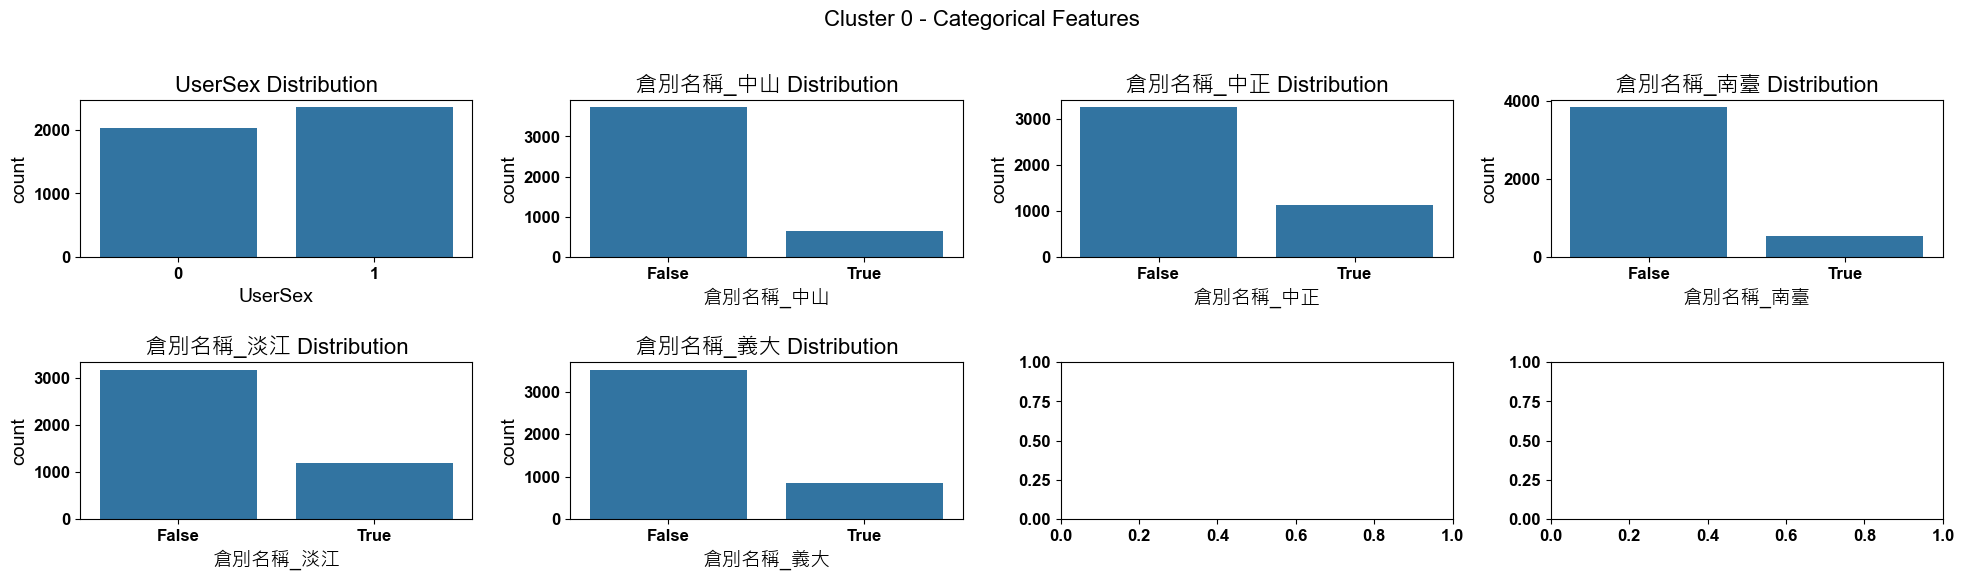

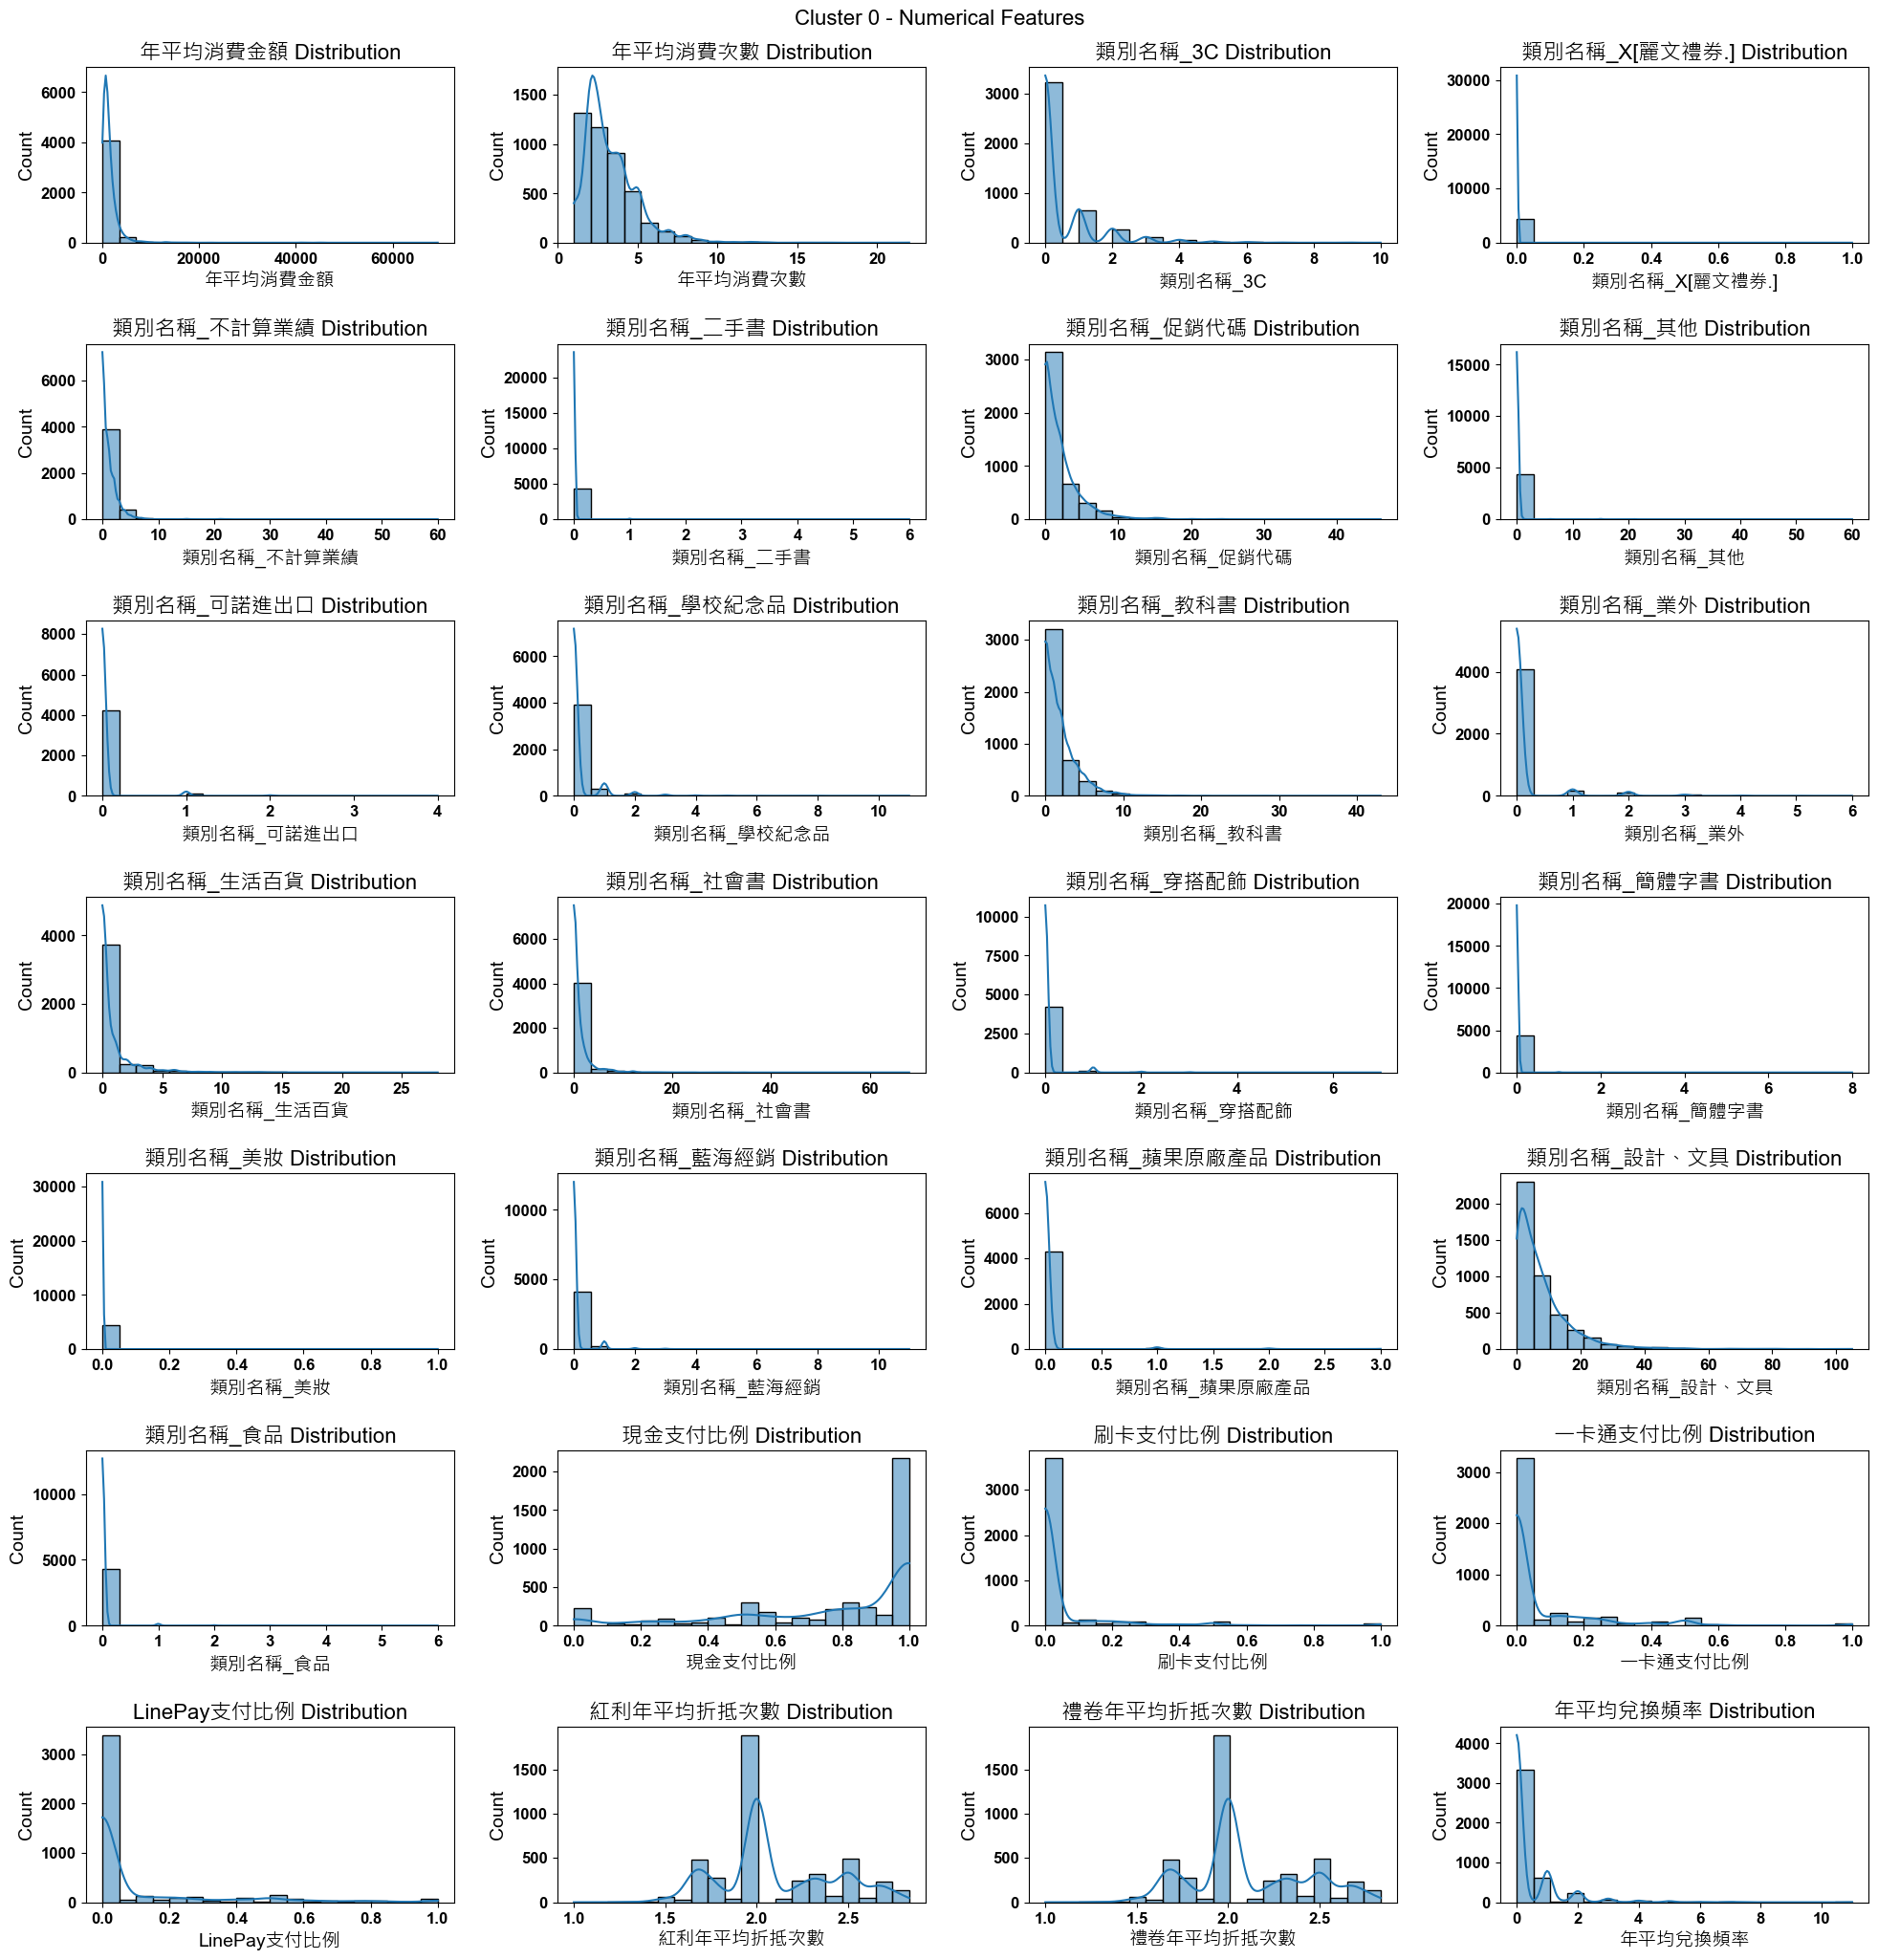

Cluster 1


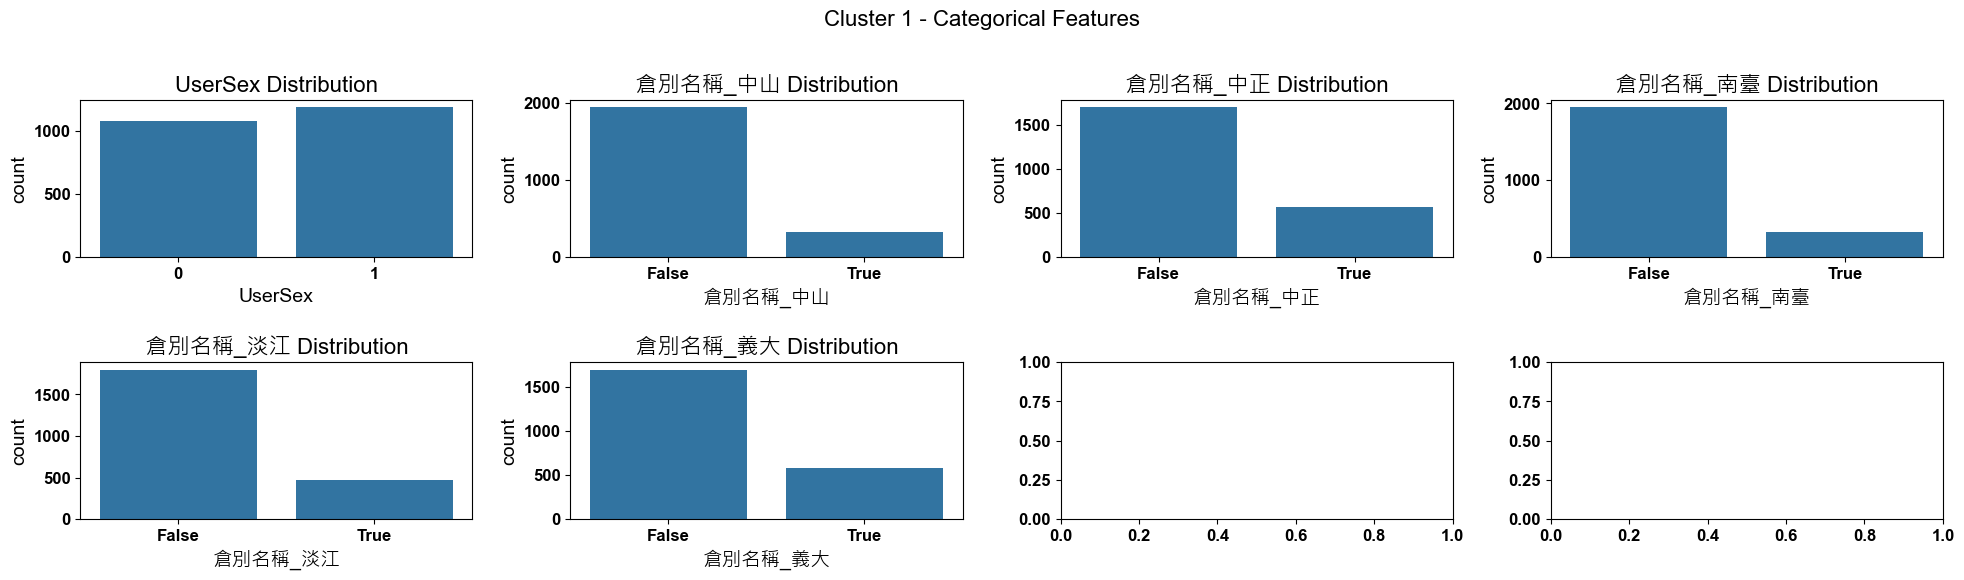

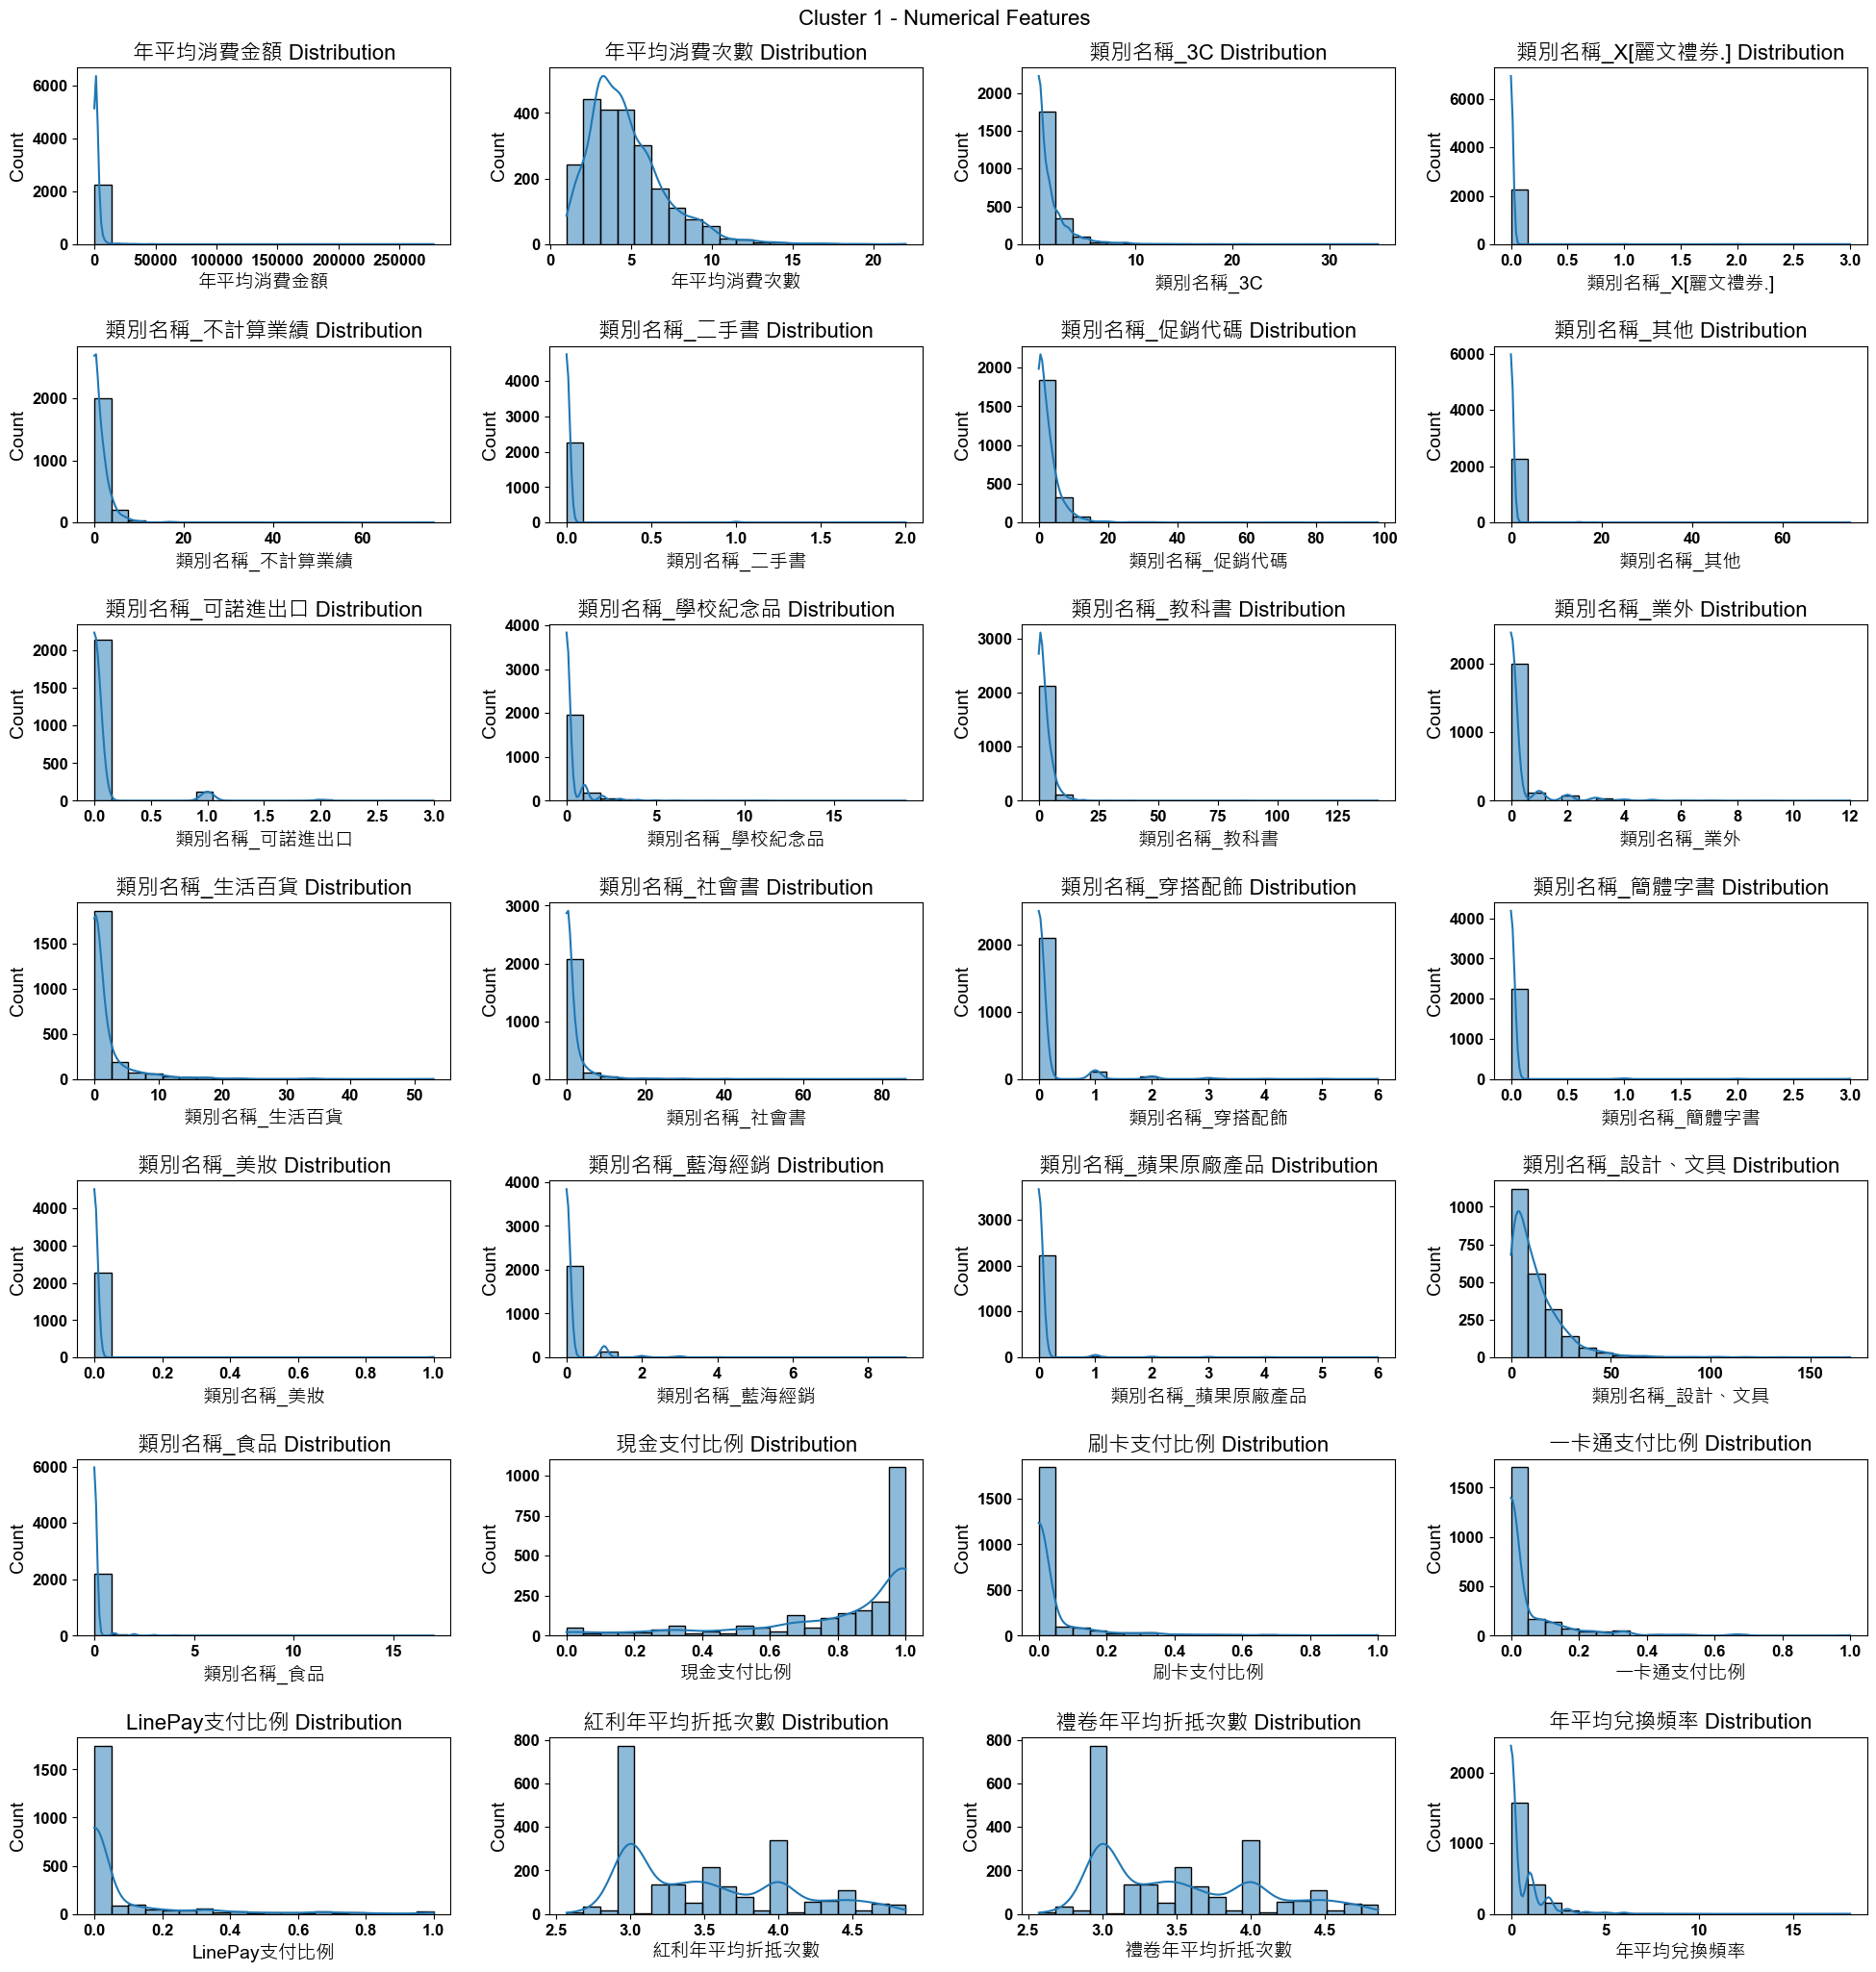

Cluster 2


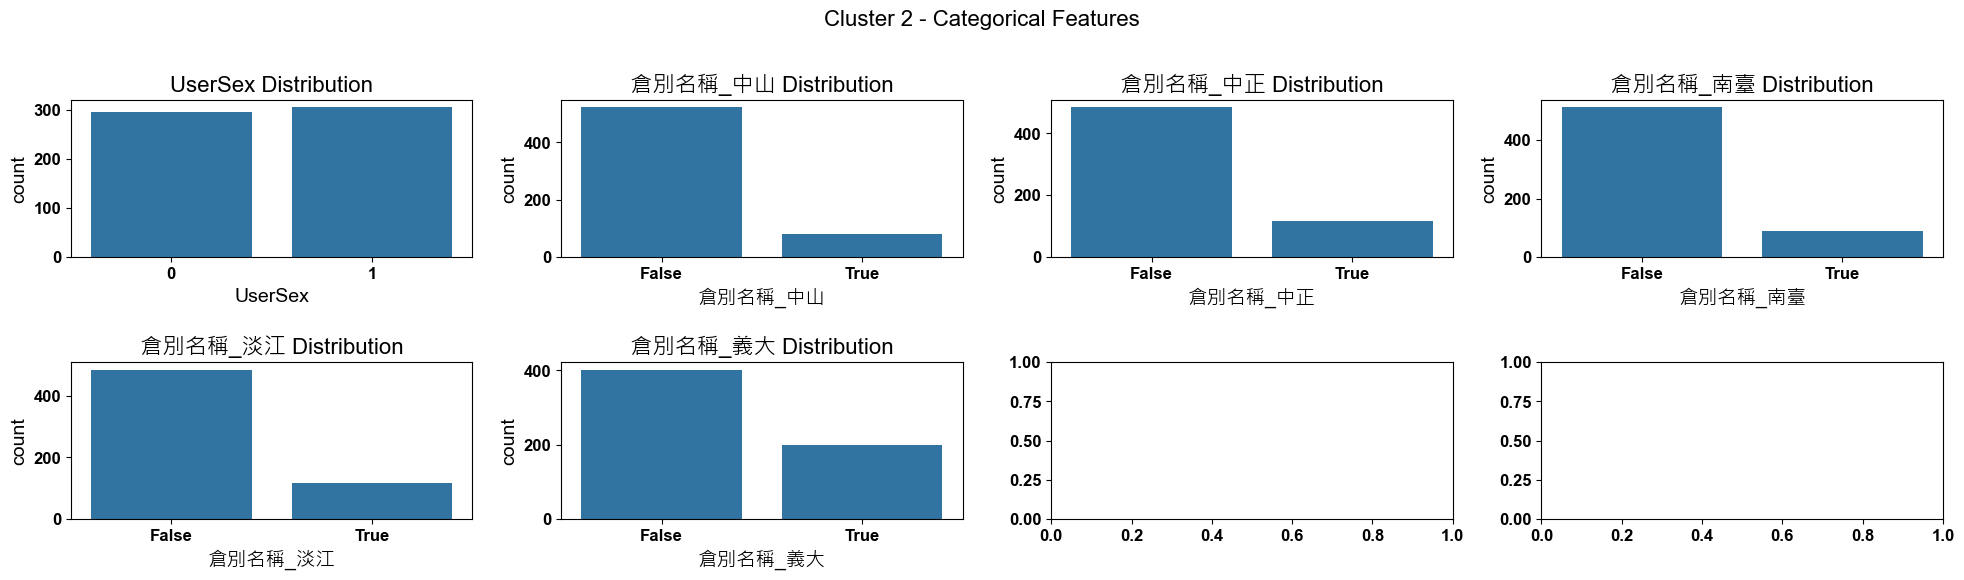

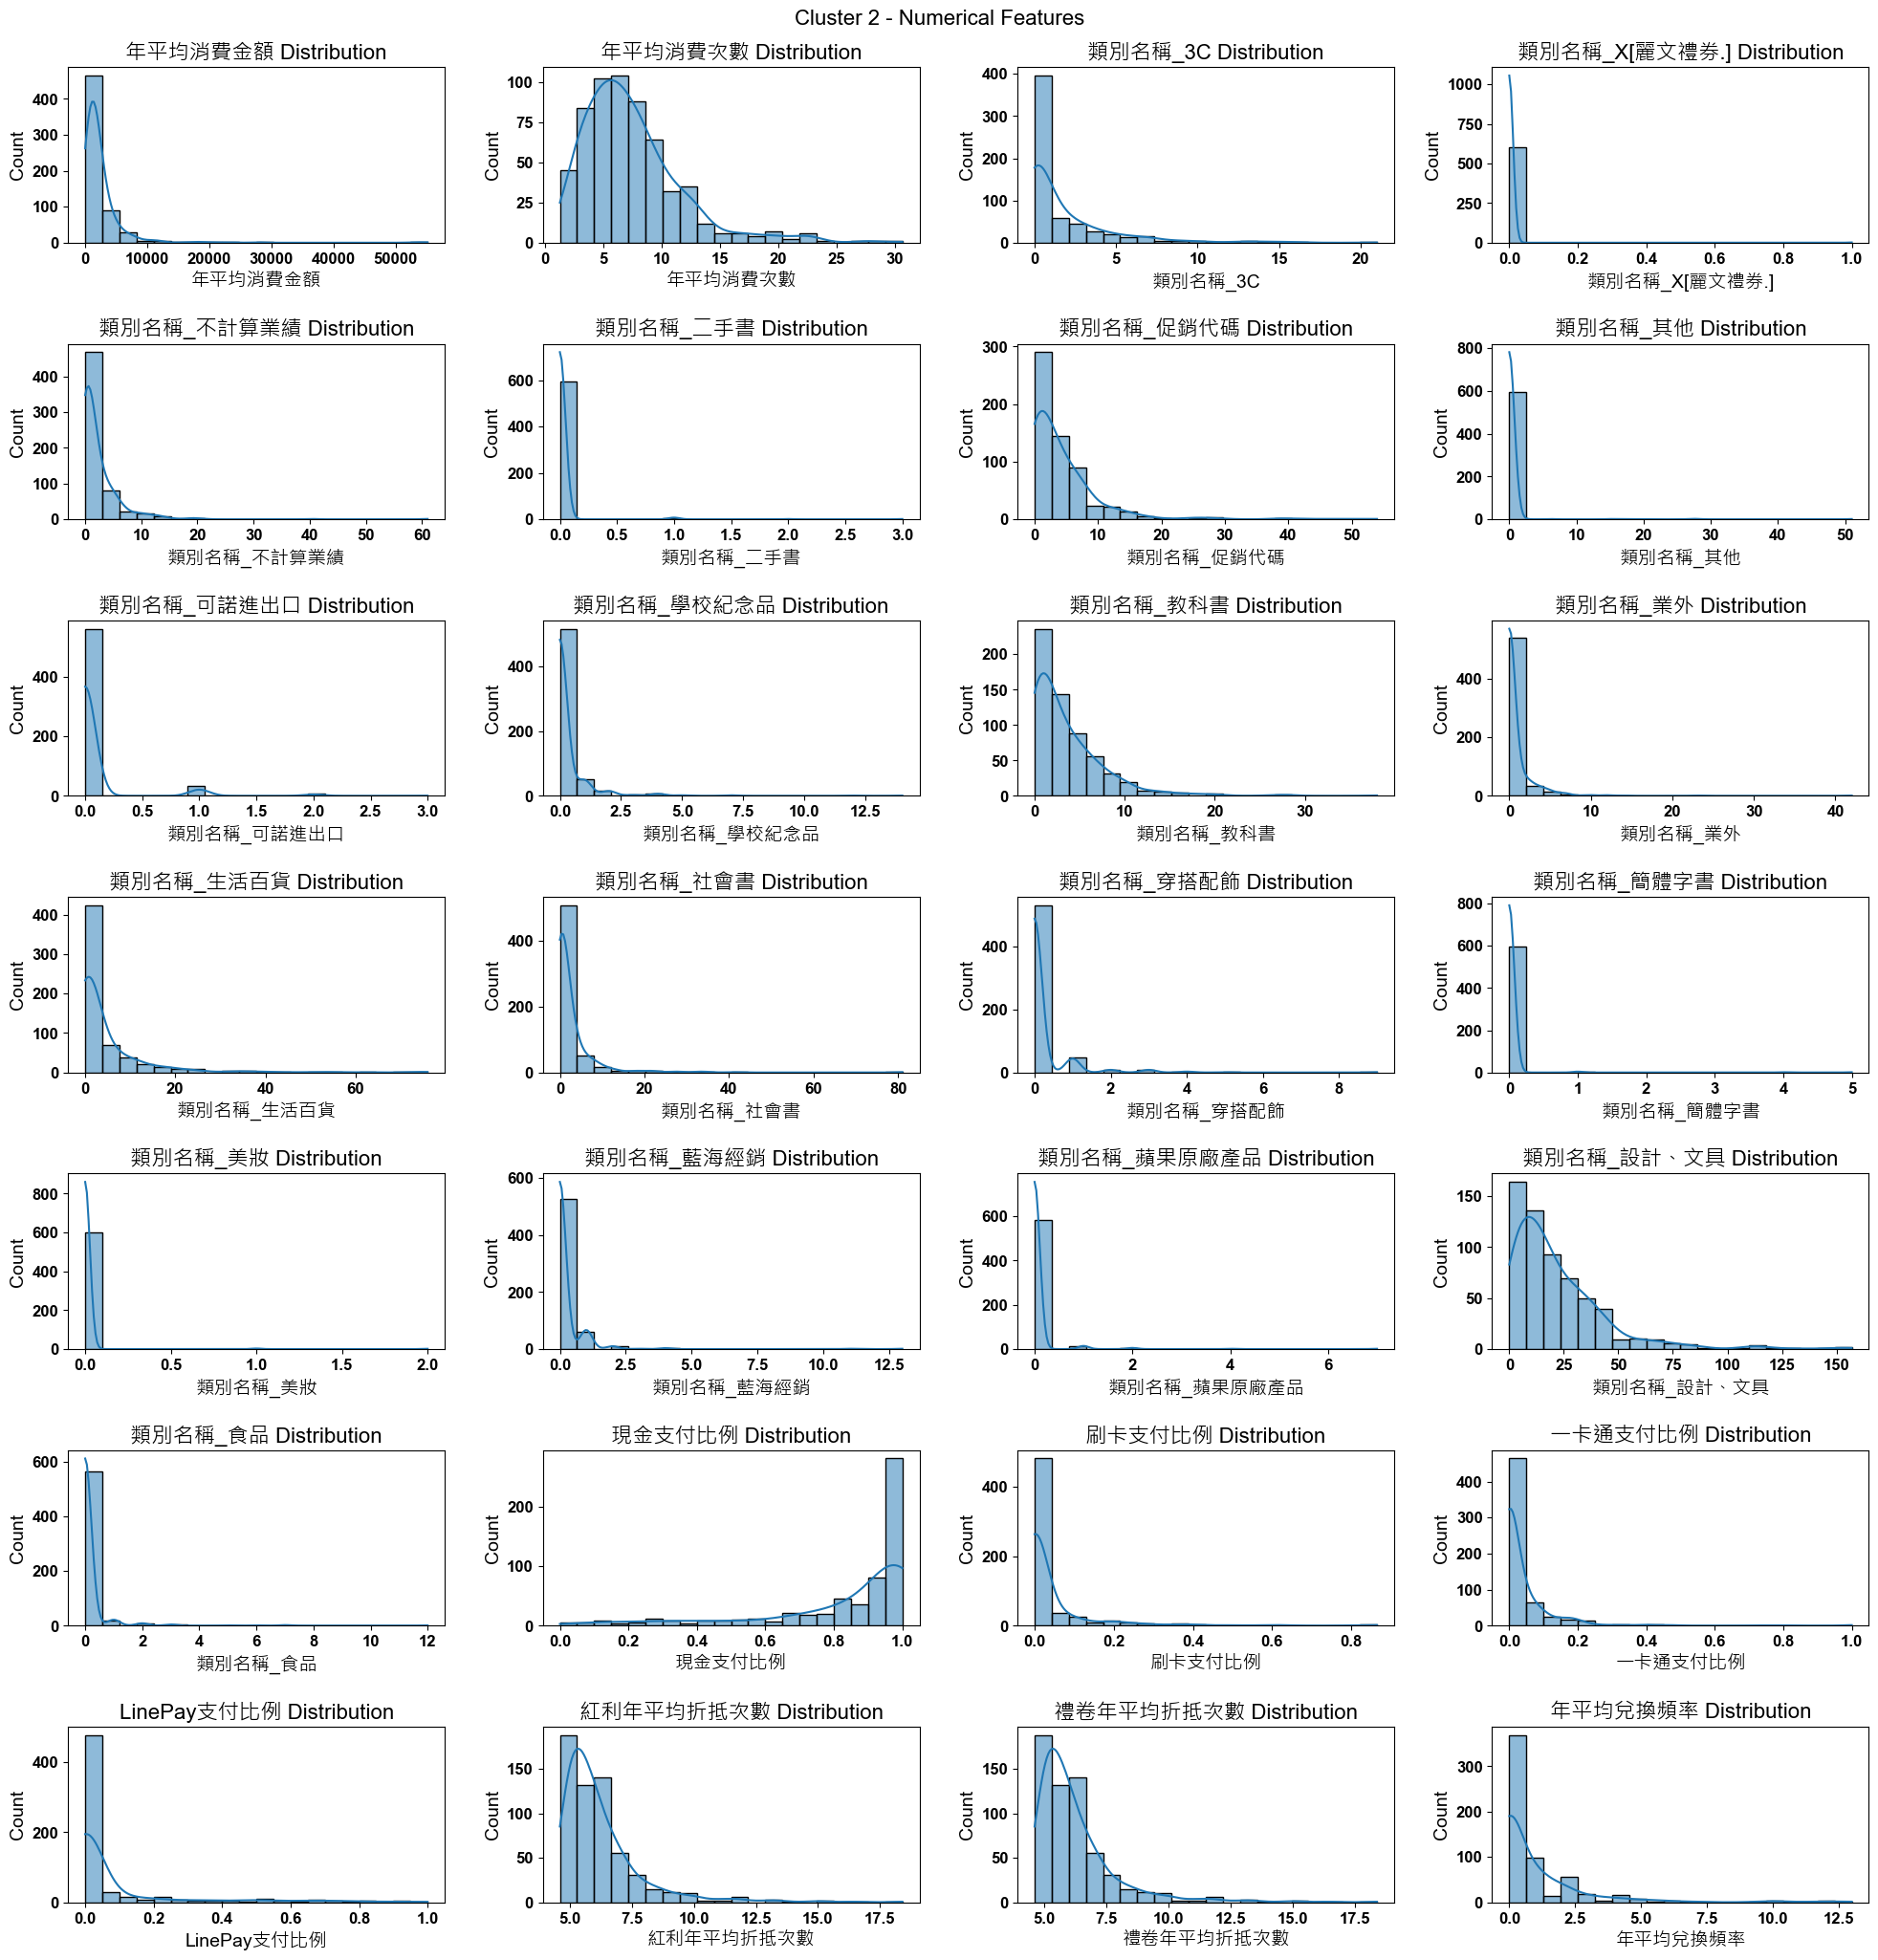

Cluster 3


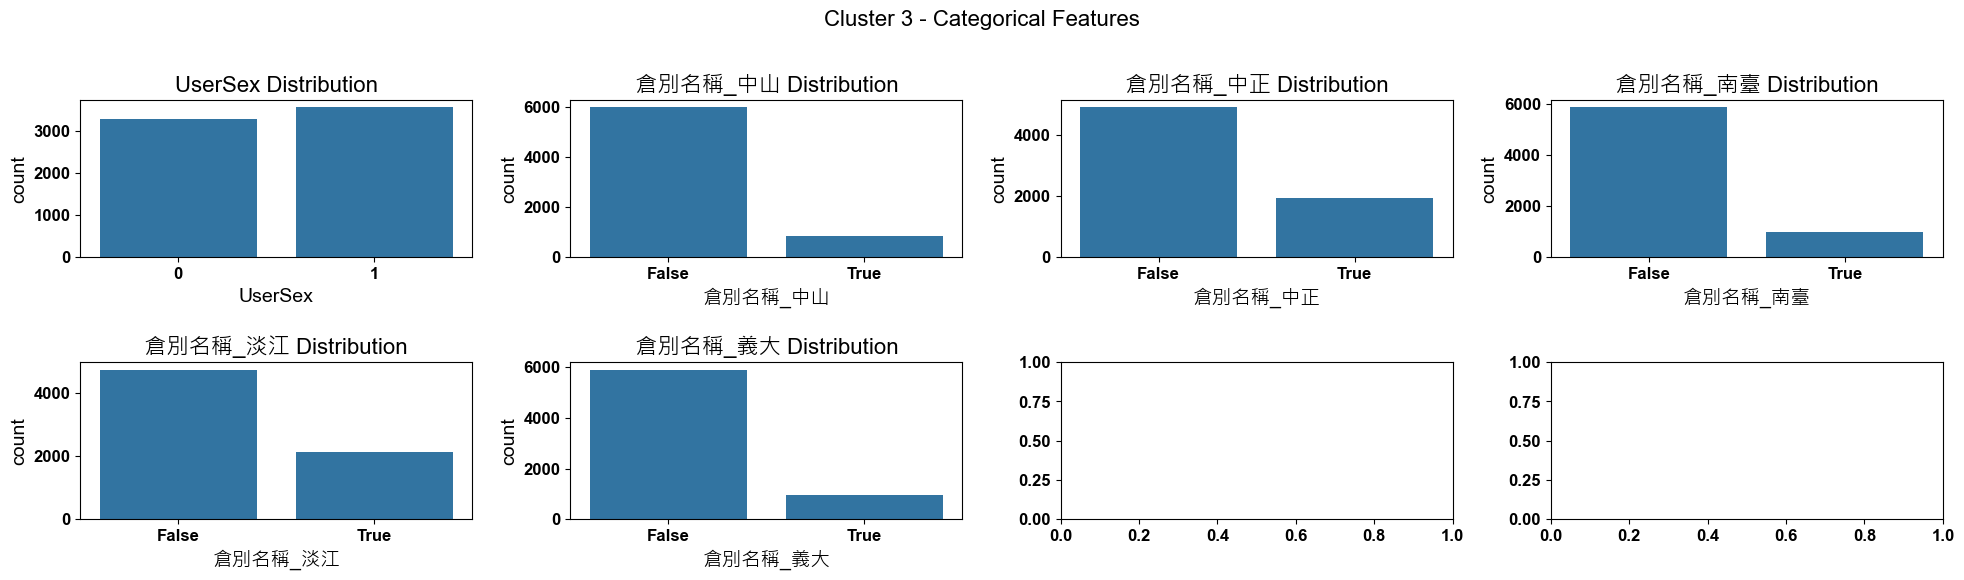

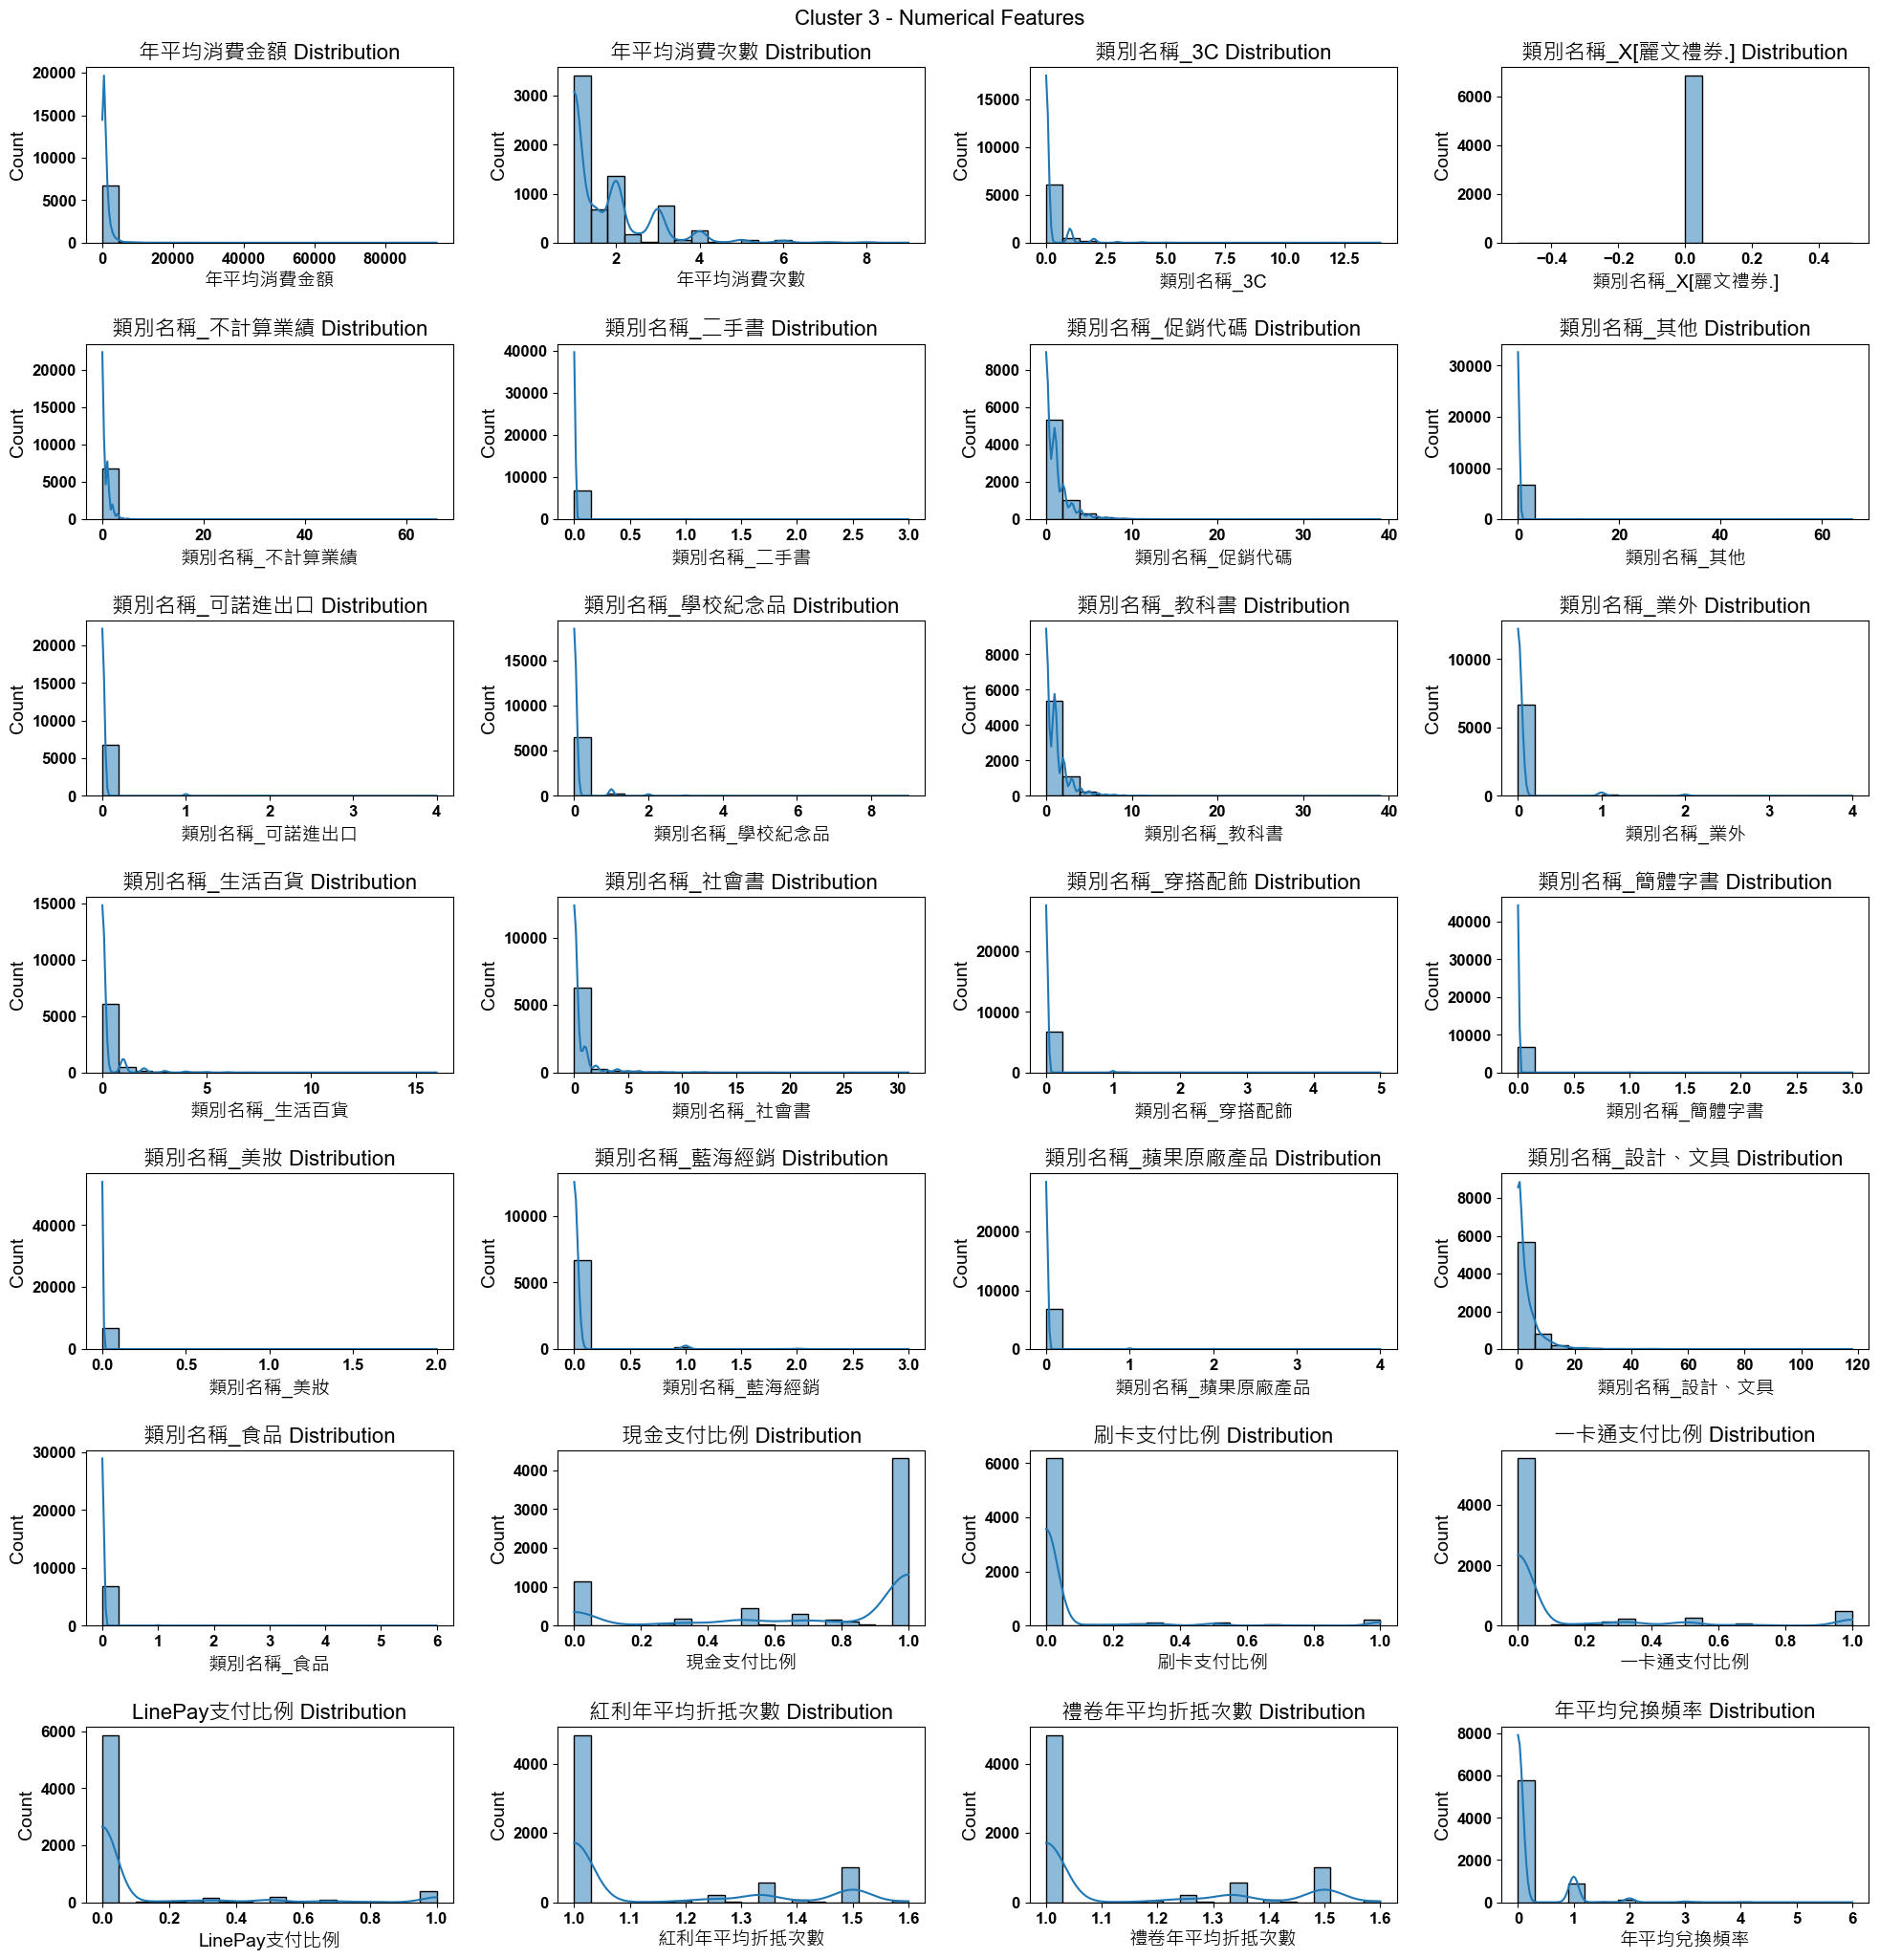

In [267]:
# 根據 Cluster 欄位分群
cluster_groups = kmeans_cluster_discountOnly.groupby('Cluster')

# 定義類別型與數值型特徵
categorical_features = ['UserSex', '倉別名稱_中山', '倉別名稱_中正', '倉別名稱_南臺', '倉別名稱_淡江', '倉別名稱_義大']
numerical_features = [col for col in kmeans_cluster_discountOnly.columns if col not in categorical_features + ['UserID', 'Cluster']]

for cluster, group in cluster_groups:
    print(f"Cluster {cluster}")

    # 計算需要的 subplot 行數
    num_categorical = len(categorical_features)
    num_numerical = len(numerical_features)

    # 設定類別特徵的圖表
    num_rows_cat = (num_categorical + 3) // 4  # 確保 subplot 數量正確
    fig_cat, axes_cat = plt.subplots(nrows=num_rows_cat, ncols=4, figsize=(20, 3 * num_rows_cat))
    fig_cat.suptitle(f'Cluster {cluster} - Categorical Features', fontsize=16)

    for i, feature in enumerate(categorical_features):
        row = i // 4
        col = i % 4
        sns.countplot(x=feature, data=group, ax=axes_cat[row, col])
        axes_cat[row, col].set_title(f'{feature} Distribution')

    plt.tight_layout(pad=2)
    plt.show()

    # 設定數值特徵的圖表
    num_rows_num = (num_numerical + 3) // 4
    fig_num, axes_num = plt.subplots(nrows=num_rows_num, ncols=4, figsize=(20, 3 * num_rows_num))
    fig_num.suptitle(f'Cluster {cluster} - Numerical Features', fontsize=16)

    for i, feature in enumerate(numerical_features):
        row = i // 4
        col = i % 4
        sns.histplot(data=group, x=feature, ax=axes_num[row, col], bins=20, kde=True)
        axes_num[row, col].set_title(f'{feature} Distribution')

    plt.tight_layout(pad=2)
    plt.show()



#### 6.4 依分群發想行銷方向
1. 將四群變成三群，分別為高價值客群(Cluster2)、新顧客客群(Cluster3)，中等價值客群(Cluster0, Cluster1)。如果考量到行銷預算，可以先從前面兩群執行，因為這兩群的消費行為與其他群組不同，其他的中等價值客戶則可以在其他檔期行銷。
    - 高價值客群:在紅利年平均折抵次數、禮券年平均折抵次數、年平均兌換頻率這三項都是最高，目的為維持其忠誠度，維持他們對品牌的黏著度
    - 新顧客客群:在上述的三項特徵都是最低，目的為引導他們使用紅利。
    - 中等價值客群:在上述的三項特徵介於高價值客群與新客群之間，目的為使其成為高價值客群

2. 行銷方向(針對客群的其他特徵思考)  
- 高價值客群


| 特徵 | 描述 |
|---------|---------|
| 消費金額 | 屬於較高消費群體，平均年消費金額較高 |
| 消費頻率 | 購買次數較多，屬於高頻消費者 |
| 常購買類別 | 主要消費在3C、設計文具、書籍，也會購買食品與美妝 |
| 支付方式 | 主要使用信用卡支付，其次是 Line Pay |
| 紅利與禮券使用率 | 高於其他群體，顯示對折扣與優惠較敏感 |

- 行銷策略
    - 增強會員消費頻率、優化支付
        - 會員專屬折扣日：週五/週末限定，高頻購買品類（3C、美妝、文具）享 9 折
        - 提升支付便利性：鼓勵使用 信用卡 & Line Pay，消費回饋2%
        - 大額消費回饋：單筆消費滿 NT$2,000 可獲 NT$100 折扣回饋



<hr>

- 新顧客客群


| 特徵 | 描述 |
|---------|---------|
| 消費金額 | 屬於低消費群體，年平均消費金額較低 |
| 消費頻率 | 購買次數較少，屬於低頻消費者 |
| 常購買類別 | 較少購買特定商品，消費品類分散 |
| 支付方式 | 使用現金為多數 |
| 紅利與禮券使用率 | 較低，顯示對折扣與優惠敏感度較低 |

- 行銷策略
    - 提升新顧客轉化
        - 購物誘因：針對首購者提供「滿額禮品」或「首購點數雙倍送」，刺激消費
        - 限時促銷：針對新客群舉辦限時促銷，例如「註冊會員 7 天內購物享獨家優惠」
        - 信用卡回饋：針對該群體推動特定信用卡合作，如「刷指定銀行信用卡享 95 折」
        - 個性化推薦：根據購物行為推薦「與過去購買商品類似的產品」

<hr>

- 中價值客群

| 特徵 | 描述 |
|---------|---------|
| 消費金額 | 屬於中等消費群體，年消費金額適中 (NT$10,000 ~ NT$20,000) |
| 消費頻率 | 消費次數適中，介於高頻與低頻消費者之間 |
| 常購買類別 | 3C、設計文具、書籍 為主要消費品類，也會購買 食品與美妝 |
| 支付方式 | 使用現金為多數，再來則是信用卡 |
| 紅利與禮券使用率 | 對折扣與紅利回饋 有一定敏感度，但不及高價值客群 |

- 行銷策略
    - 連續消費獎勵：針對連續 3 個月內消費達標者，提供下一期 NT$100 禮券，提升顧客留存率
    - 線上下單，實體店取貨享 免運 + 3% 折扣，鼓勵顧客線上下單，提高實體店來客數。
    - 搭配購物折扣：購買 3C 產品 + 相關配件 (如筆電 + 滑鼠 / 設計文具組合) 可享 滿 NT$3,000 享 9 折，鼓勵顧客一次購買多品類商品。